<a href="https://colab.research.google.com/github/UberEth/Covid-Analysis-Colab/blob/master/Covid_19_NotebookV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Project Introduction**
**This notebook pulls COVID case, death and hospitalization data over time.**

It clones the repo managed by Johns Hopkins and the COVID Data Project from the following repositories:

* https://github.com/CSSEGISandData/COVID-19 
* https://github.com/COVID19Tracking







# **Foundation Code**

## Clone GIT Repos



In [0]:
### Clone Johns Hopkins / COVID Data Project data

!rm -r '/content/COVID-19'
!git clone https://github.com/CSSEGISandData/COVID-19.git || (cd COVID-19 ; git pull)
!pwd

!rm -r '/content/covid-tracking-data'
!git clone https://github.com/COVID19Tracking/covid-tracking-data.git || (cd covid-tracking-data ; git pull)

!git clone https://github.com/UberEth/Data-Science-DataSets.git || (cd Data-Science-DataSets; git pull)

#Data Engineering step - pop first 2 lines of cdc.csv file
!tail -n -62 covid-tracking-data/data/cdc.csv > covid-tracking-data/data/cdc2.csv


Cloning into 'COVID-19'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 32753 (delta 20), reused 28 (delta 17), pack-reused 32718
Receiving objects: 100% (32753/32753), 164.71 MiB | 29.58 MiB/s, done.
Resolving deltas: 100% (19359/19359), done.
/content
Cloning into 'covid-tracking-data'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 4618 (delta 28), reused 38 (delta 16), pack-reused 4566
Receiving objects: 100% (4618/4618), 4.86 MiB | 22.22 MiB/s, done.
Resolving deltas: 100% (3260/3260), done.
Cloning into 'Data-Science-DataSets'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 1), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [0]:
!git clone https://github.com/UberEth/Data-Science-DataSets.git || (cd Data-Science-DataSets; git pull)


fatal: destination path 'Data-Science-DataSets' already exists and is not an empty directory.
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/UberEth/Data-Science-DataSets
   97a78e5..583e67f  master     -> origin/master
Updating 97a78e5..583e67f
Fast-forward
 US-County-Detail.csv | 2960 ++++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 2960 insertions(+)
 create mode 100644 US-County-Detail.csv


## **Establish Python Environment/Utilities**




In [0]:
# Setup Python Environment
import io, pandas as pd, matplotlib.pyplot as plt, datetime as dt, numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats.mstats import gmean
from datetime import date
import seaborn

import warnings
warnings.filterwarnings('ignore')

print(dt.datetime.now())
yesterday = dt.datetime.now() - dt.timedelta(days=1)
yesterday_str = yesterday.strftime("%m-%d-%Y")
yesterday_csv = yesterday.strftime("%m-%d-%Y") + ".csv"
print("Yesterday's Date: {0}, CSV FILE: {1}".format(yesterday,yesterday_csv))
print('\n\n\n\n')

# Flags for setting verbosity level for notebook
verbose = False
transpose = True
sums = False

def zero_date(theDate):
  return theDate.strftime("%-m/%-d/%-y")

# Function Library
def print_details(name='Data Source Details', df=''):
    
    f = open('/content/workfile','w+')  
    print("---------------------------------------------------------------------")
    print("------- ", name)
    print("---------------------------------------------------------------------")

    md_buffer = df.to_markdown() 
    f.write(md_buffer)
    f.close()

    !head -20 '/content/workfile'
    print(df.columns)
    print("\n\n")
    
    !rm /content/workfile

def prep_list_of_str(str_list):
  i = 0
  ret_str = ""
  sizeofList = len(str_list) 
  while i < sizeofList :
    ret_str = ret_str + str_list[i] + ', '
    i += 1

  return ret_str[:-2]

def add_date(row, date_string, flag):
  month = date_string[0:2]
  day = date_string[3:5]
  year = date_string[6:10]
  full_date = year+'-'+month+'-'+day

  dt_date = date(int(year), int(month), int(day))
  week_number = dt_date.isocalendar()[1]
  
  if flag == 'Y':
    return int(year)
  elif flag == 'D':
    return int(day)
  elif flag == 'M':
    return int(month)
  elif flag == 'F': #datetime
    return dt_date
  elif flag == 'F1': #string
    return full_date
  elif flag == 'W':
    return week_number
  elif flag == 'S':
    return get_season(date_string)
  elif flag == 'Q':
    return get_calendar_qtr(date_string)
  else: return ''

def get_calendar_qtr(date_string):
  month = int(date_string[0:2])
  if month >=1 and month <=3: return 1
  elif month >3 and month <=6: return 2
  elif month >6 and month <=9: return 3
  elif month >9 and month <=12: return 4
  else: return '0'

def get_season(date_string):
  month = date_string[0:2]
  day = date_string[3:5]

  ordinal = int(month+day)
  
  if ((ordinal>1221 and ordinal < 1231) or (ordinal>101 and ordinal <321)) :
      return 'Winter'
  elif ordinal >= 321 and ordinal <621:
      return 'Spring'
  elif ordinal >= 621 and ordinal <921:
      return 'Summer'
  elif ordinal >=921 and ordinal <1221:
      return 'Fall'
  else:
      return 'Error'

print(prep_list_of_str(['Jan', 'Feb', 'March']))
print(zero_date(dt.datetime.now()))


2020-06-13 17:20:40.113992
Yesterday's Date: 2020-06-12 17:20:40.114203, CSV FILE: 06-12-2020.csv





Jan, Feb, March
6/13/20


# Data Load/Prep

# Comparing the correlation of daily deaths to confirmed

K, so if we look at where the daily deaths correlate to confirmed/deaths, there's now a 5-10 day lag between daily deaths and daily confirmed.

The guestimate are now consistantly underestimating cumulative deaths, which indicates that testing is finally improving (or that deaths are being more-under reported this week than normal). For a while, they were not underestimating deaths and that was not a good sign.

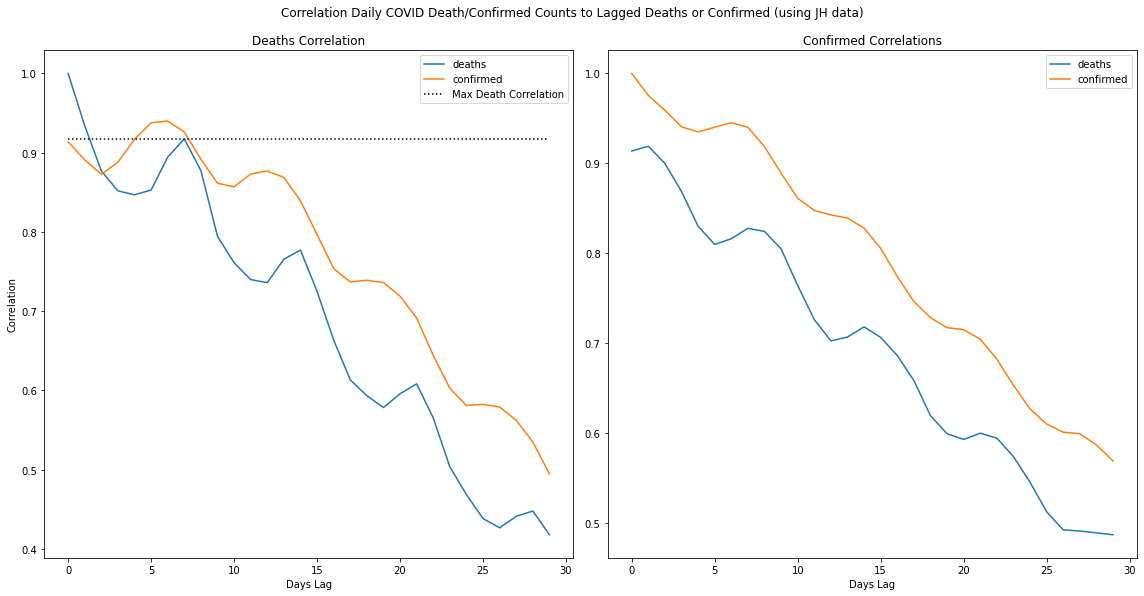

In [0]:

# deaths = global_deaths
# cofirmed = global_confirmed
deaths = global_deaths.copy()
confirmed = global_confirmed.copy()

deaths = deaths.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()
confirmed = confirmed.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()

deaths = deaths.T
confirmed = confirmed.T

nations = {}
for nation in deaths.columns:
  nations[nation] = deaths[[nation]]
  nations[nation].columns = ["deaths"]
  nations[nation]["confirmed"] = confirmed[nation]


tmp = nations["US"][["deaths", "confirmed"]]
tmp.index = pd.to_datetime(tmp.index)

my_range = 30

corr_tmp = (tmp.diff())
for i in range(my_range):
  corr_tmp["deaths_lag_{}".format(i)] = corr_tmp["deaths"].shift(i).fillna(0)
  corr_tmp["confirmed_lag_{}".format(i)] = corr_tmp["confirmed"].shift(i).fillna(0)


corr_df = corr_tmp.corr()
death_corrs = pd.DataFrame()
confirmed_corrs = pd.DataFrame()

for i in range(my_range):
  death_corrs.loc()[i, "deaths"] = corr_df.loc()["deaths", "deaths_lag_{}".format(i)]
  death_corrs.loc()[i, "confirmed"] = corr_df.loc()["deaths", "confirmed_lag_{}".format(i)]

  confirmed_corrs.loc()[i, "deaths"] = corr_df.loc()["confirmed", "deaths_lag_{}".format(i)]
  confirmed_corrs.loc()[i, "confirmed"] = corr_df.loc()["confirmed", "confirmed_lag_{}".format(i)]


fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16,8), facecolor="w")

death_corrs.plot(title="Deaths Correlation", ax=ax1)
death_corrs["cutoff"] = death_corrs[2:].deaths.max()
death_corrs["cutoff"].plot(ax=ax1, c="black", style=":", label="Max Death Correlation")
ax1.set_xlabel("Days Lag")
ax1.set_ylabel("Correlation")

ax1.legend()

confirmed_corrs.plot(title="Confirmed Correlations", ax=ax2)
ax2.set_xlabel("Days Lag")
fig.suptitle("Correlation Daily COVID Death/Confirmed Counts to Lagged Deaths or Confirmed (using JH data)", y=1.03)
fig.tight_layout()



# Time Series Data Load/Prep

## Load COVID Data into Pandas Dataframes
Loads Data From
1. Johns Hopkins Time Series Reports
2. Johns Hopkins Daily Reports
3. COVID-19 Open Data Hospitalization Data
4. Supporting Data Sets (County Demographices etc., )

Creates Summaries and Trasnpose dataframes where applicable.



### COVID TIME SERIES REPORTS - Data Load / Prep

In [0]:
                                               # Set Analytics Max Date
# Import Hopkins COVID Data Sets
# Global JH Time Series Detail
global_deaths = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
global_confirmed = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
# Create Transpose(s)
G_D_T = global_deaths.T
G_D_C = global_confirmed.T
if verbose: print_details('Global Deaths', global_deaths)
if verbose: print_details('Global Confirmed', global_confirmed)
if transpose: print_details('Tranpose of Global Deaths', G_D_T)
if transpose: print_details('Transpose of Global Confirmed', G_D_C)

# US JH Time Series Detail
US_deaths = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
US_confirmed = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
# Create Transpose(s)
US_D_T = US_deaths.T
US_C_T = US_confirmed.T
if verbose: print_details('US Deaths',US_deaths)
if verbose: print_details('US Confirmed', US_confirmed)
if transpose: print_details('Transpose of US Deaths',US_D_T)
if transpose: print_details('Transpose of US Confirmed', US_C_T)

# Yesterday's Daily Data Sets
# Global JH Daily Data
global_daily = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + yesterday_csv)
global_daily.rename(columns={"Admin2":"County/Sector","Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)
# Create Transpose
G_DAY_T = global_daily.T
if verbose: print_details('Global Daily Data deaths/confirmed', global_daily)
if transpose: print_details('Transpose of Global Daily', G_DAY_T)

# US JH Daily Data
US_daily = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/" + yesterday_csv)
US_daily.rename(columns={"Admin2":"County/Sector","Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)
# Create Transpose
US_DAY_T = US_daily.T
if verbose: print_details('US Daily Data deaths/confirmed', US_daily)
if transpose: print_details('Transpose of US Daily Data', US_DAY_T)

# Summarize JH Global Time Series Date
global_deaths_sum = global_deaths.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()
global_confirmed_sum = global_confirmed.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()
# Create Transpose(s)
G_D_S_T = global_deaths_sum.T
G_C_S_T = global_confirmed_sum.T
if sums: print_details('Global Deaths Summarized', global_deaths_sum)
if sums: print_details('Global Confirmed Summarized', global_confirmed_sum)
if transpose: print_details('Transpose of Global Deaths Summarized', G_D_S_T)
if transpose: print_details('Transpose of Global Confirmed Summarized',G_C_S_T) 

# Group JH US Time Series by State, Date
US_deaths_by_state_sum = US_deaths.drop(["Lat", "Long_", 'UID', 'code3', "FIPS", "iso2", "iso3", "Country_Region"], axis=1).groupby(["Province_State"]).sum()
US_confirmed_by_state_sum = US_confirmed.drop(["Lat", "Long_", "UID", "code3", "FIPS", "iso2", "iso3", "Country_Region"], axis=1).groupby(["Province_State"]).sum()
# Create Transpose(s)
US_D_STATE_T = US_deaths_by_state_sum.T
US_C_STATE_T = US_confirmed_by_state_sum.T
if sums: print_details('US Deaths Summarized', US_deaths_by_state_sum)
if sums: print_details('US Confirmed Summarized', US_confirmed_by_state_sum)
if transpose: print_details('Transpose of US Deaths Summarized', US_D_STATE_T)
if transpose: print_details('Transpose of US Confirmed Summarized', US_C_STATE_T) 

# Group JH US Time Series by State, County, Date
US_deaths_by_state_county_sum = US_deaths.drop(["Lat", "Long_", 'UID', 'code3', "FIPS", "iso2", "iso3"], axis=1).groupby(["Country_Region","Province_State", "Admin2"]).sum()
US_confirmed_by_state_county_sum = US_confirmed.drop(["Lat", "Long_", "UID", "code3", "FIPS", "iso2", "iso3"], axis=1).groupby(["Country_Region", "Province_State", "Admin2"]).sum()
# Create Transpose(s)
US_D_STATE_CTY_T = US_deaths_by_state_county_sum.T
US_C_STATE_CTY_T = US_confirmed_by_state_county_sum.T
if sums: print_details('US Deaths by State/County Summarized', US_deaths_by_state_county_sum)
if sums: print_details('US Confirmed by State/County Summarized',US_confirmed_by_state_county_sum)
if transpose: print_details('Transpose of US Deaths State/County Summarized',US_D_STATE_CTY_T)
if transpose: print_details('Transpose of US Confirmed State/County Summarized', US_C_STATE_CTY_T) 



---------------------------------------------------------------------
-------  Tranpose of Global Deaths
---------------------------------------------------------------------
|                | 0           | 1       | 2       | 3       | 4        | 5                   | 6         | 7       | 8                            | 9               | 10                 | 11         | 12              | 13        | 14        | 15                | 16      | 17         | 18       | 19      | 20         | 21       | 22      | 23      | 24     | 25      | 26       | 27                     | 28       | 29       | 30       | 31           | 32         | 33       | 34       | 35        | 36               | 37             | 38       | 39            | 40                        | 41          | 42       | 43                   | 44       | 45           | 46                       | 47      | 48       | 49       | 50       | 51        | 52       | 53       | 54        | 55       | 56       | 57       | 58       |

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



RangeIndex(start=0, stop=3738, step=1)



---------------------------------------------------------------------
-------  Transpose of US Daily Data
---------------------------------------------------------------------
|                      | 0                   | 1                   | 2                   | 3                   | 4                   | 5                   | 6                   | 7                   | 8                   | 9                   | 10                   | 11                  | 12                  | 13                  | 14                  | 15                  | 16                  | 17                  | 18                  | 19                  | 20                  | 21                  | 22                  | 23                  | 24                  | 25                  | 26                  | 27                  | 28                  | 29                  | 30                  | 31                  | 32                  | 33                  | 34      

### COVID DAILY REPORTS -  Data Load/Prep

In [0]:
# Aggregate daily report US data 
tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + yesterday_csv)
tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State", "Latitude":'Lat', "Longitude":'Long_', "Last Update":'Last_Update'}, inplace=True)

#filter non US Data 
#tmp = tmp[tmp['Country/Region'] == 'US']

#parse date, season
tmp['Year'] = tmp.apply(lambda row: add_date(row, yesterday_csv, 'Y'), axis=1)
tmp['Day'] = tmp.apply(lambda row: add_date(row, yesterday_csv, 'D'), axis=1)
tmp['Month'] = tmp.apply(lambda row: add_date(row, yesterday_csv, 'M'), axis=1)
tmp['Date'] = tmp.apply(lambda row: add_date(row, yesterday_csv, 'F'), axis=1)
tmp['Week'] = tmp.apply(lambda row: add_date(row, yesterday_csv, 'W'), axis=1)
tmp['Season'] = tmp.apply(lambda row: add_date(row, yesterday_csv, 'S'), axis=1)
tmp['Calendar_Quarter'] = tmp.apply(lambda row: add_date(row, yesterday_csv, 'Q'), axis=1)

for x in os.listdir("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"):
    if not x.endswith("2020.csv"):
        continue
    try:
      tmp1 = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
      tmp1.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State", "Latitude":'Lat', "Longitude":'Long_', "Last Update":'Last_Update'}, inplace=True)
      
      #filter non US Data
      #tmp1 = tmp1[tmp1['Country/Region'] == 'US']

      #parse dates
      tmp1['Year'] = tmp1.apply(lambda row: add_date(row, x, 'Y'), axis=1)
      tmp1['Day'] = tmp1.apply(lambda row: add_date(row, x, 'D'), axis=1)
      tmp1['Month'] = tmp1.apply(lambda row: add_date(row, x, 'M'), axis=1)
      tmp1['Date'] = tmp1.apply(lambda row: add_date(row, x, 'F'), axis=1)
      tmp1['Week'] = tmp1.apply(lambda row: add_date(row, x, 'W'), axis=1)
      tmp1['Season'] = tmp1.apply(lambda row: add_date(row, x, 'S'), axis=1)
      tmp1['Calendar_Quarter'] = tmp1.apply(lambda row: add_date(row, x, 'Q'), axis=1)
      tmp = tmp.append(tmp1, ignore_index=True)
    except:
      pass

tmp["Date"] = pd.to_datetime(tmp["Date"], format="%Y-%m-%d")

#tmp.shape
#tmp.to_csv('working-output/aggregate_daily.csv')

#Filter US Data Only
US_data = tmp[tmp["Country/Region"] == 'US']
GLOBAL_data = tmp[tmp["Country/Region"] != 'US']

#Build Indexes
US_data['Datetime'] = pd.to_datetime(US_data['Date'])
#US_data = US_data.set_index('Datetime')
US_data.drop(['Date'], axis=1, inplace=True)

GLOBAL_data['Datetime'] = pd.to_datetime(GLOBAL_data['Date'])
#GLOBAL_data = GLOBAL_data.set_index('Datetime')
GLOBAL_data.drop(['Date'], axis=1, inplace=True)


In [71]:
#Test Harness

us = US_data.copy()
print(us[20000:20050].to_markdown())
us.info()

glob = GLOBAL_data.copy()
#print(glob[1000:1100].to_markdown())
#glob.info()




|       |   FIPS | Admin2          | Province/State   | Country/Region   | Last_Update         |     Lat |     Long_ |   Confirmed |   Deaths |   Recovered |   Active | Combined_Key                    |   Incidence_Rate |   Case-Fatality_Ratio |   Year |   Day |   Month |   Week | Season   |   Calendar_Quarter | Datetime            |
|------:|-------:|:----------------|:-----------------|:-----------------|:--------------------|--------:|----------:|------------:|---------:|------------:|---------:|:--------------------------------|-----------------:|----------------------:|-------:|------:|--------:|-------:|:---------|-------------------:|:--------------------|
| 22807 |  23023 | Sagadahoc       | Maine            | US               | 2020-04-15 22:56:51 | 43.9542 |  -69.8507 |          15 |        0 |           0 |       15 | Sagadahoc, Maine, US            |              nan |                   nan |   2020 |    15 |       4 |     16 | Spring   |                  2 | 2020-04-15 00:

### COVID HOSPITALIZATION - Data Load/Prep

In [0]:
# ------------------------------------------------------------------
# COVID Data Project Loads - COVID Hospitalization Data US
# __________________________________________________________________

cdc_daily = pd.read_csv("covid-tracking-data/data/cdc2.csv")
if verbose: print_details('CDC Daily Statistics', cdc_daily)

# county data feed is broken
# county_hosp = pd.read_csv("covid-tracking-data/data/counties.csv")
# if verbose: print(county_hosp)

states_current_hosp = pd.read_csv("covid-tracking-data/data/states_current.csv")
if verbose: print_details('US States Current Hospitalization', states_current_hosp)
states_daily_hosp = pd.read_csv("covid-tracking-data/data/states_daily_4pm_et.csv")
if verbose: print_details('US States Daily Hospitalization',states_daily_hosp)
states_info_hosp = pd.read_csv("covid-tracking-data/data/states_info.csv")
if verbose: print_details('US States Hospitalization Info',states_info_hosp)
us_current_hosp = pd.read_csv("covid-tracking-data/data/us_current.csv")
if verbose: print_details('US Current Hospitalization', us_current_hosp)
us_daily_hosp = pd.read_csv("covid-tracking-data/data/us_daily.csv")
if verbose: print_details('US Daily Hospitalization', us_daily_hosp)


### SUPPORTING DATA SETS - Data Load/Prep

In [0]:
US_county_demographics = pd.read_csv("Data-Science-DataSets/US-County-Detail.csv")
US_county_demographics = US_county_demographics.set_index('FIPS')

In [77]:
a = us.copy()
a.rename(columns = {'Admin2': 'County','Province/State': 'State' },inplace=True)
print(a.shape)
print(a.info())
print(a[1:20].to_markdown())

b = US_county_demographics.copy()
print(b.info)
print(b[1:20].to_markdown())

# Join US Daily with US COUNTY DETAILS by FIPS CODES
inner = pd.merge(a, b, on=['FIPS'], how='left')
print(inner.shape)
print(inner.info())
print(inner.head(50).to_markdown())


(245780, 21)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 245780 entries, 0 to 280873
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   FIPS                 242976 non-null  float64       
 1   County               243625 non-null  object        
 2   State                245780 non-null  object        
 3   Country/Region       245780 non-null  object        
 4   Last_Update          245780 non-null  object        
 5   Lat                  241098 non-null  float64       
 6   Long_                241098 non-null  float64       
 7   Confirmed            245780 non-null  float64       
 8   Deaths               245750 non-null  float64       
 9   Recovered            245750 non-null  float64       
 10  Active               244220 non-null  float64       
 11  Combined_Key         244220 non-null  object        
 12  Incidence_Rate       47730 non-null   float64       
 13  C

# OLD ANALYSIS


Warning: New York Numbers differ from the offiial NY State numbers, https://covid19tracker.health.ny.gov/views/NYS-COVID19-Tracker/NYSDOHCOVID-19Tracker-Fatalities?%3Aembed=yes&%3Atoolbar=no&%3Atabs=n. I think it's because JHU includes suspected but not confirmed deaths from NYC https://www1.nyc.gov/site/doh/covid/covid-19-data.page.

In [0]:
def convert_to_date(aString):
  date_portion = aString[:10]
  return dt.datetime.strptime(date_portion, '%Y-%m-%d')


a='2020-06-12 05:09:52'
print(a[:10])

print(convert_to_date(a))

2020-06-12
2020-06-12 00:00:00


In [0]:
DEATH_CUTOFF = 200
DEATH_LOW = 1500
DEATH_HIGH = 2500

us_deaths = pd.DataFrame()
state_deaths = pd.DataFrame()

# get cumulative deaths from yesterday for each state
col = zero_date(yesterday)
cum_deaths = US_deaths_by_state_sum.copy()
t1 = cum_deaths.reset_index()
t2 = t1.set_index('Province_State', drop = False)
target_states = {}
#print(t2.loc[:,col])


for ind in t2.index: 
     if t2[col][ind] >=DEATH_LOW and t2[col][ind] <= DEATH_HIGH:
      target_states[t2['Province_State'][ind]] = t2[col][ind]
      #print(t2['Province_State'][ind], t2[col][ind])
#print(target_states)

# Aggregate daily report data 
tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + yesterday_csv)
tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

us_deaths.loc[yesterday_csv[:-4], "CUMULATIVE"] = tmp[tmp["Country/Region"] == "US"]["Deaths"].sum()
state_deaths[yesterday_csv[:-4]] =tmp[tmp["Country/Region"] == "US"].groupby('Province/State').sum()["Deaths"]

for x in os.listdir("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"):
    if not x.endswith("2020.csv"):
        continue
    try:
      tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
    except:
      pass
    tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

    us_deaths.loc[x[:-4],"CUMULATIVE"] = tmp[tmp["Country/Region"] == "US"]["Deaths"].sum()
    state_deaths[x[:-4]]=tmp[tmp["Country/Region"] == "US"].groupby('Province/State').sum()["Deaths"]

us_deaths.sort_index(inplace=True)
us_deaths.index = pd.to_datetime(us_deaths.index)

state_deaths = state_deaths[sorted([x for x in state_deaths.columns])].fillna(0)
td = us_deaths[us_deaths.CUMULATIVE > 20].T

#Set up to go a few days into the future
maxDate = td.columns.max()
try:
  for i in range(1,7):
      td[str(maxDate + dt.timedelta(days=i))] = np.NaN
except:
  pass
td = td.T

td.index = pd.to_datetime(td.index)
td["day"] = range(len(td))

#print(us_deaths.to_markdown())
#print(state_deaths.to_markdown())
#print(td.to_markdown())

#Figure out math for exponents for exponential growth
days = pd.DataFrame()
days["d"] = range(2,10)

#daily rate to double every x days
days["r"] = days.d.apply(lambda x: 2**(1/(x)))
#print(days.to_markdown())

#Give value of expected value along each exponential for doubling period
for i in range(len(days)):
 td["{} Day Double".format(i+2)] = td["day"].apply(lambda x: 20 *(days.r[i]**x))
#print(td.to_markdown())

#set up plots
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(16,16), facecolor="w")
td[[x for x in td.columns if x != "day"]].plot(style=["o-", ":", ":", ":", ":", ":"], title="National: Linear Scale", ax = ax1)
ax1Max = td["CUMULATIVE"].max()

td[[x for x in td.columns if x != "day"]].plot(style=["o-", ":", ":", ":", ":", ":"], title="National: Log Scale", ax = ax2)
#fulocs, fulabels = ax2.yticks()

ax1.set_ylim((0, ax1Max*2))
ax1.yaxis.tick_left()
ax1.yaxis.set_ticks_position('both')

ax2.set_ylim((1, ax1Max*32))
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks_position('both')

#shinanigans to make these plot together with bar
td = td.diff()[["CUMULATIVE"]].rename(columns={"CUMULATIVE":"INCREASE"})
td.index = pd.to_datetime(td.index)
#td.loc()[td.index[0], "ACTUAL CHANGE"] = 0
td.fillna(0, inplace=True)

ax1tmp = ax1.twiny()
td.plot(kind='bar', color="lightblue", ax=ax1tmp)
ax1tmp.set_xticklabels([])

ax2.set_ylim(20)
ax2.set_yscale("log")
#ax2tmp = ax2.twiny()
#td.plot(kind='bar', color="lightblue", ax=ax2tmp)
#ax2tmp.set_xticklabels([])
#ax2tmp.yaxis.set_ticks_position("none")

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax1tmp.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.1, 0.5))

#ax2tmp.get_legend().remove()
#shinanigans done
ax1tmp.get_legend().remove()
ax1.get_legend().remove()

#
#
#  BY STATE
#
#

# Stat names in columns, dates in rows, value=deaths
tmp = state_deaths.T

#Create DF for each state, keeping only days where cumulative deaths is above DEATH_CUTOFF
state_dfs = {}
state_names ={}

for state in target_states:
  state_dfs[state] = tmp[[state]]
  #logit=state_dfs[state][state] >= DEATH_CUTOFF
  #print(state_dfs[state][logit])
  #state_dfs[state] = state_dfs[state][logit]
  logit = state_dfs[state][state] >= 0
  state_dfs[state] = state_dfs[state][logit]
  #print(state_dfs[state])

max_days = 0
max_deaths = 0

display_at_end = []

#for each state, if more than 2 days above DEATH_CUTOFF deaths, plot it
for state in state_dfs:
  if len(state_dfs[state]) > 2:
      if len(state_dfs[state]) > max_days:
          max_days = len(state_dfs[state])

      asdf = state_dfs[state].copy()
      if asdf[state].max() > max_deaths:
          max_deaths = asdf[state].max()


      #resetting index to days at DEATH_CUTOFF or more
      asdf.index = range(0, len(asdf))
      asdf.plot(ax=ax3, style="o-")
      asdf.plot(ax=ax4, style="o-", logy=True)

      end_df = state_dfs[state][-1:]
      end_df = end_df.astype(str)
      end_df += " (+"
      end_df += state_dfs[state].diff().dropna()[-1:].astype(str)
      end_df += ")"

      display_at_end.append(end_df)

#set up my extrapolation on the exponentials figuring out the doubling rates
days = pd.DataFrame()
days["d"] = range(0,10)
#daily rate to double every x days
days["r"] = days.d.apply(lambda x: 2**(1/(x)) if x > 0 else np.NaN)

td = pd.DataFrame([x for x in range(max_days + 6)])
td.columns=["day"]

for i in range(len(days)):
  td["{} Day Double".format(i)] = td["day"].apply(lambda x:DEATH_CUTOFF *(days.r[i]**x))

td = td.shift()
td = td[1:]
#gonna plot exponentials directly so dropping the "day" column
td.drop(columns="day", inplace=True)
td.index = range(len(td))

#td.index = td.index-1

td[[column for column in td.columns if not column.startswith("0")]].plot(style=":", ax=ax3)
td[[column for column in td.columns if not column.startswith("0")]].plot(style=":", ax=ax4)

ax3.set_title("By State - Linar Scale")
ax3.set_xlabel("days since hitting {} deaths".format(DEATH_CUTOFF))
ax3.get_legend().remove()
ax4.yaxis.tick_right()


#just make the ymax a bit higher
ax3.set_ylim(0, max_deaths * 2)

ax4.set_title("By State - Log Scale")
ax4.yaxis.tick_right()
ax4.yaxis.set_ticks_position('both')
ax4.set_xlabel("days since hitting {} deaths".format(DEATH_CUTOFF))
ax4.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

fig.suptitle("{} - Cumulative US COVID Deaths (data from johns hopkins)".format(us_deaths.index.max().strftime("%m-%d-%Y")), y=1.03, fontsize=14, weight="bold")

fig.tight_layout()

plt.show()

print("\n\nlast run: {} UTC".format(dt.datetime.now()))
display(pd.concat([state for state in display_at_end], axis=1))
display(us_deaths[-8:])



#So since it correlates, can we extrapolate forward?

> Indented block



In [0]:
## so let's be super lazy and just take the lag from max correlation as how far we can look ahead, then go and do that!
##(It would do better with moving average, but that's another issue)

#pretty sure I messed up the math a bit somewhere so it's off by a day probably

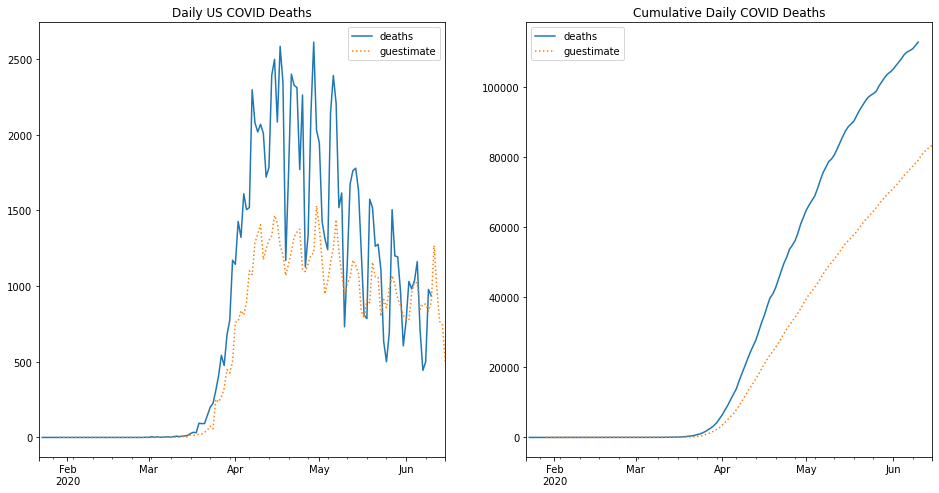

deaths    guestimate
2020-06-10  112924.0  79197.966144
2020-06-11       NaN  80465.533513
2020-06-12       NaN  81443.867823
2020-06-13       NaN  82210.066876
2020-06-14       NaN  82952.117359
2020-06-15       NaN  83451.244213

In [0]:
# deaths = global_deaths
# cofirmed = global_confirmed
deaths = global_deaths.copy()
confirmed = global_confirmed.copy()
max_correlation_days_lag = death_corrs[["confirmed"]].idxmax()[0]
my_range = 30


deaths = deaths.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()
confirmed = confirmed.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()

deaths = deaths.T
confirmed = confirmed.T

nations = {}
for nation in deaths.columns:
  nations[nation] = deaths[[nation]]
  nations[nation].columns = ["deaths"]
  nations[nation]["confirmed"] = confirmed[nation]

tmp = nations["US"][["deaths", "confirmed"]]

corr_tmp = (tmp.diff())
for i in range(my_range):
  corr_tmp["deaths_lag_{}".format(i)] = corr_tmp["deaths"].shift(i).fillna(0)
  corr_tmp["confirmed_lag_{}".format(i)] = corr_tmp["confirmed"].shift(i).fillna(0)

corr_df = corr_tmp.corr()
death_corrs = pd.DataFrame()
confirmed_corrs = pd.DataFrame()

for i in range(my_range):
  death_corrs.loc()[i, "deaths"] = corr_df.loc()["deaths", "deaths_lag_{}".format(i)]
  death_corrs.loc()[i, "confirmed"] = corr_df.loc()["deaths", "confirmed_lag_{}".format(i)]

daily_deaths = tmp.diff()
daily_deaths.index = pd.to_datetime(daily_deaths.index)

mean_ratio = np.mean([((daily_deaths["deaths"][-i])/(daily_deaths["confirmed"][-i - max_correlation_days_lag+1])) for i in range(1,21)])

daily_deaths["guestimate"] =  mean_ratio * daily_deaths["confirmed"].shift(max_correlation_days_lag)
startForecast = daily_deaths.index.max()
cvals = daily_deaths.confirmed[-max_correlation_days_lag:]

for forecast in range(1,max_correlation_days_lag):
  daily_deaths.at[startForecast + dt.timedelta(days=forecast), "guestimate"] = mean_ratio * cvals[forecast-max_correlation_days_lag-1]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16,8), facecolor="w")
daily_deaths[["deaths", "guestimate"]].plot(ax=ax1, style=["-", ":"], title="Daily US COVID Deaths")

#(mean_ratio * daily_deaths["confirmed"]).shift(7).plot(ax=ax1)

daily_deaths[["deaths", "guestimate"]].cumsum().plot(ax=ax2, style=["-", ":"], title="Cumulative Daily COVID Deaths")

plt.show()

display(daily_deaths[["deaths","guestimate"]].cumsum()[-max_correlation_days_lag:])

comparison = daily_deaths.copy() #will use this later

In [0]:
mean_ratio

0.04347072112164656

Would this have worked for last 10 day? Let's go back in time and find out!

And the answer is, it overshoots by a bit! probably because the testing's been increasing on non-covid maybe?

I feel like doing some stuff with a MA window might improve this to get past some of the noise, but I gotta get back to working on my thesis edits

0 Days Ago  ... 6 Days Ago
CumErrorRatio Yesterday (By Guestimate Ratio Date)     -26.7%  ...     -15.8%

[1 rows x 7 columns]

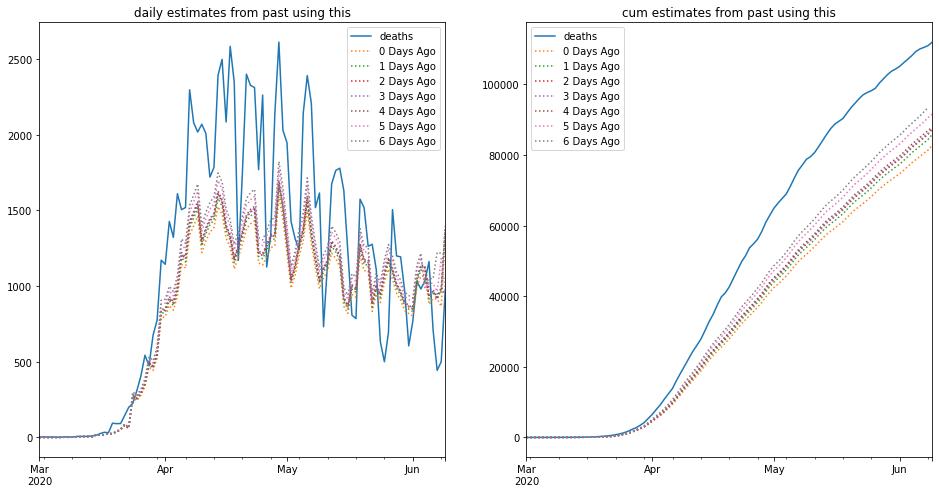

In [0]:
import datetime

tmp.index=pd.to_datetime(tmp.index)

daily_deaths_original = tmp.diff()
daily_deaths_compare = tmp.diff()[["deaths"]]

daily_deaths_original.index = pd.to_datetime(daily_deaths_original.index)

for j in range(7):
  daily_deaths = daily_deaths_original[:-1-j]
  #print(len(daily_deaths))
  mean_ratio = np.mean([((daily_deaths["deaths"][-i])/(daily_deaths["confirmed"][-i - max_correlation_days_lag])) for i in range(1,21)])
  #print(mean_ratio)
  daily_deaths["guestimate"] =  mean_ratio*daily_deaths["confirmed"].shift(max_correlation_days_lag)
  startForecast = daily_deaths.index.max()
  cvals = daily_deaths.confirmed[-max_correlation_days_lag:]
  for forecast in range(1,7):
    daily_deaths.at[startForecast + dt.timedelta(days=forecast), "guestimate"] = mean_ratio * cvals[forecast-max_correlation_days_lag]
  daily_deaths_compare["{} Days Ago".format(j)] = daily_deaths["guestimate"]
  #daily_deaths[["deaths", "guestimate"]].plot(title=j)

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16,8), facecolor="w")

markers = ["-"] + [":" for x in range(7)]

daily_deaths_compare[daily_deaths_compare.index >= datetime.datetime(2020,3,1)].plot(ax=ax1, style=markers, title="daily estimates from past using this")
daily_deaths_compare.cumsum()[daily_deaths_compare.index >= datetime.datetime(2020,3,1)].plot(ax=ax2, style=markers, title="cum estimates from past using this")

final_compare = daily_deaths_compare.cumsum()[-2:-1]
idx = final_compare.index[-1]
ratio_df = pd.DataFrame()

for col in daily_deaths_compare.columns:
  if col == "deaths":
    continue
  ratio_df.at["CumErrorRatio Yesterday (By Guestimate Ratio Date)", col] = np.round(100*(final_compare.at[idx, col]-final_compare.at[idx, "deaths"])/final_compare.at[idx, "deaths"],1).astype("str")+"%"

display(ratio_df)


#Comparing deaths by country after hitting a death threshold

Below is the 5 day moving average for the percent change in total deaths by country on the nth day after hitting specified deaths. The United States and France are not going the right direction here. Oh, wait, why did I keep log scale?

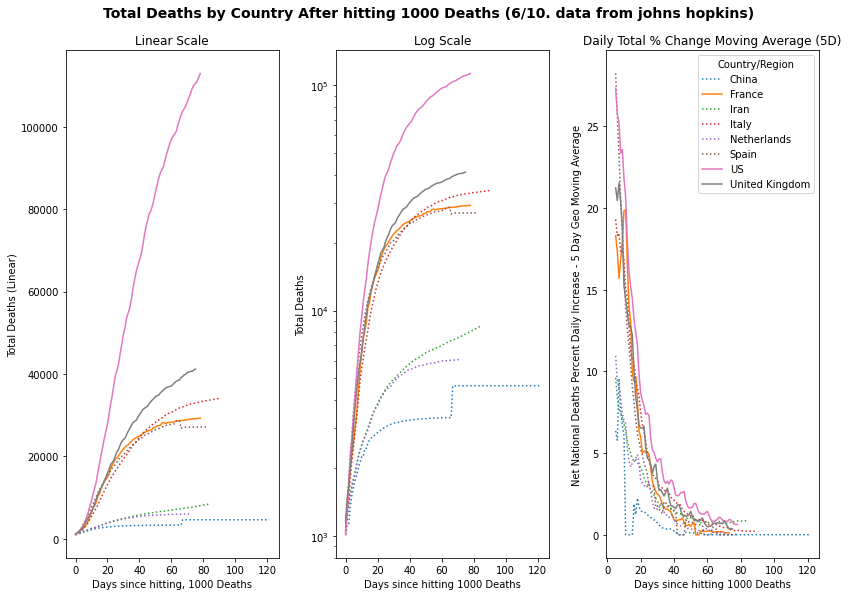

In [0]:
# Source File
country_deaths = global_deaths.copy()

# Calculated from this date (date reached the death_metric)
death_metric_date = "4/1/20"

# Number of deaths to use as baseline
death_metric = 1000

fig, [ax1, ax2, ax3] = plt.subplots(nrows = 1, ncols =3, figsize=(12,8), facecolor="w")

country_deaths = country_deaths.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()
country_deaths = country_deaths[country_deaths[death_metric_date] > death_metric]
country_deaths = country_deaths.T
country_percent_deaths = (country_deaths.diff()/country_deaths.shift())

for country in country_deaths.columns:
    df = country_deaths[[country]]
    df = df[df[country] > death_metric]
    df = 100*(df.diff()/df.shift())
    df = df.rolling(5).agg(gmean).dropna()
    if len(df) < 3:
        continue

    style = ":"
    if country == "US" or country == "France" or country== "United Kingdom":
      style = "-"

    df.index = range(5, len(df)+5)
    df.plot(ax=ax3, style=style)
    df = country_deaths[[country]]
    df = df[df[country] >= death_metric]
    df.index = range(len(df))

    df.plot(ax=ax1, style=style, logy=False)

    df.plot(ax=ax2, style=style, logy=True)

ax1.get_legend().remove()
ax2.get_legend().remove()

ax1.set_ylabel("Total Deaths (Linear)")
ax2.set_ylabel("Total Deaths")
ax3.set_ylabel("Net National Deaths Percent Daily Increase - 5 Day Geo Moving Average")

ax1.set_xlabel("Days since hitting, {} Deaths".format(death_metric))
ax2.set_xlabel("Days since hitting {} Deaths".format(death_metric))
ax3.set_xlabel("Days since hitting {} Deaths".format(death_metric))

ax1.set_title("Linear Scale")
ax2.set_title("Log Scale")
ax3.set_title("Daily Total % Change Moving Average (5D)")

fig.suptitle("Total Deaths by Country After hitting {} Deaths ({}. data from johns hopkins)".format(death_metric, "/".join(country_deaths.index[-1].split("/")[:2])), y=1.03, fontsize=14, weight="bold")
fig.tight_layout()
plt.show()


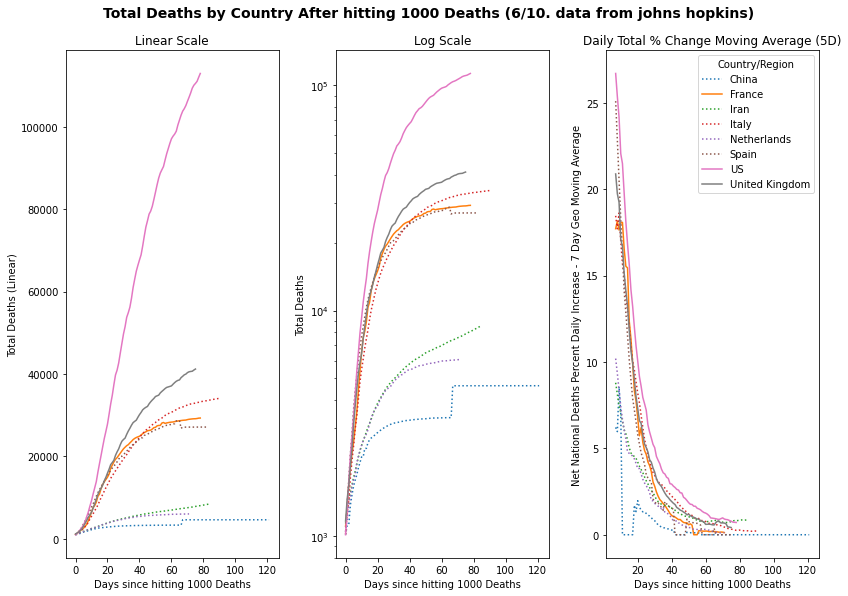

Country/Region      US
6/8/20          111011
6/9/20          111989
6/10/20         112924

In [0]:
# Source File
country_deaths = global_deaths.copy()

# Calculated from this date (date reached the death_metric)
death_metric_date = "4/1/20"

# Number of deaths to use as baseline
death_metric = 1000

# Moving Average Range
mar = 7

# Countries to Compare
C1='US'
C2='France'
C3='United Kingdom'


fig, [ax1, ax2, ax3] = plt.subplots(nrows = 1, ncols =3, figsize=(12,8), facecolor="w")

country_deaths = country_deaths.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()
country_deaths = country_deaths[country_deaths[death_metric_date] > death_metric]
country_deaths = country_deaths.T
country_percent_deaths = (country_deaths.diff()/country_deaths.shift())

for country in country_deaths.columns:
    df = country_deaths[[country]]
    df = df[df[country] > death_metric]
    df = 100*(df.diff()/df.shift())
    df = df.rolling(mar).agg(gmean).dropna()
    if len(df) < 3:
        continue
    style = ":"
    if country == C1  or country == C2  or country== C3 :
      style = "-"

    df.index = range(mar, len(df)+mar)
    df.plot(ax=ax3, style=style)
    df = country_deaths[[country]]
    df = df[df[country] >= death_metric]
    df.index = range(len(df))

    df.plot(ax=ax1, style=style, logy=False)
    df.plot(ax=ax2, style=style, logy=True)

ax1.get_legend().remove()
ax2.get_legend().remove()

ax1.set_ylabel("Total Deaths (Linear)")
ax2.set_ylabel("Total Deaths")
ax3.set_ylabel("Net National Deaths Percent Daily Increase - {} Day Geo Moving Average".format(mar))

ax1.set_xlabel("Days since hitting {} Deaths".format(death_metric))
ax2.set_xlabel("Days since hitting {} Deaths".format(death_metric))
ax3.set_xlabel("Days since hitting {} Deaths".format(death_metric))

ax1.set_title("Linear Scale")
ax2.set_title("Log Scale")
ax3.set_title("Daily Total % Change Moving Average (5D)")

fig.suptitle("Total Deaths by Country After hitting {} Deaths ({}. data from johns hopkins)".format(death_metric,"/".join(country_deaths.index[-1].split("/")[:2])), y=1.03, fontsize=14, weight="bold")
fig.tight_layout()
plt.show()

display(country_deaths[["US"]][-3:])    


# What if we exclude some states?

In [0]:

#LOAD US DAILY DATA from JH
tmp = US_daily.copy()
df = pd.DataFrame()

tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

# establish states to be eliminated
exclude =["New York", "New Jersey", "California"]
#exclude = ["New York", "New Jersey"]
exclude_str = prep_list_of_str(exclude)
if exclude_str == '':
  exclude_str = "No States Excluded"
else:
  exclude_str = exclude_str + " Excluded"

# create targets list eliminating all those in 
targets = [x for x in tmp[(tmp["Country/Region"] == "US")]["Province/State"].unique() if x not in exclude]

# interesction with targets creates a dataframe w/o excluded states
tmp = tmp[tmp["Province/State"].isin(targets)]
#print(tmp["Province/State"].isin(targets))
#print(tmp)

#create new dataframe rows (for today's daily)
df.loc[yesterday_csv[:-4], "deaths"] = tmp[(tmp["Country/Region"] == "US")]["Deaths"].sum()
df.loc[yesterday_csv[:-4], "confirmed"] = tmp[tmp["Country/Region"] == "US"]["Confirmed"].sum()

# iterate over all daily files - summarize death/confirmed by date
for x in os.listdir("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"):
  if not x.endswith("2020.csv"):
      continue
  try:
    tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
  except:
    pass
  tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

  tmp = tmp[tmp["Province/State"].isin(targets)]

  df.loc[x[:-4], "deaths"] = tmp[tmp["Country/Region"] == "US"]["Deaths"].sum()
  df.loc[x[:-4], "confirmed"] = tmp[tmp["Country/Region"] == "US"]["Confirmed"].sum()

#print("XXX",x[:-4])
#print(df.shape)
#print(df)

# sort index (the date, x[:4]) and cast that index to datetime data type
df.sort_index(inplace=True)
df.index = pd.to_datetime(df.index)
#print(df)

# copy to tmp
tmp = df.copy()
my_range = 30

# turn corr_tmp in daily deltas
corr_tmp = (tmp.diff())
#print('tmp.diff',corr_tmp)

#creates shifted correlation data frame indexed by i of deaths/confirmed
for i in range(my_range):
  corr_tmp["deaths_lag_{}".format(i)] = corr_tmp["deaths"].shift(i).fillna(0)
  corr_tmp["confirmed_lag_{}".format(i)] = corr_tmp["confirmed"].shift(i).fillna(0)

#print(corr_tmp.to_markdown())

#run correlation on df
corr_df = corr_tmp.corr()
#print(corr_df)

death_corrs = pd.DataFrame()
confirmed_corrs = pd.DataFrame()

#creates 
for i in range(my_range):
  death_corrs.loc()[i, "deaths"] = corr_df.loc()["deaths", "deaths_lag_{}".format(i)]
  death_corrs.loc()[i, "confirmed"] = corr_df.loc()["deaths", "confirmed_lag_{}".format(i)]

print(death_corrs.to_markdown())

#obtain the largest confirmed correlation lag off shifted df -> changed to deaths instead of confirmed
max_correlation_days_lag = death_corrs[["confirmed"]].idxmax()[0]

print('Days Lag: ', max_correlation_days_lag)

daily_deaths = tmp.diff()
daily_deaths.index = pd.to_datetime(daily_deaths.index)
print(daily_deaths.to_markdown())

mean_ratio = np.mean([((daily_deaths["deaths"][-i])/(daily_deaths["confirmed"][-i - max_correlation_days_lag+1])) for i in range(1,21)])
print('mean-ratio',mean_ratio)

daily_deaths["guestimate"] =  mean_ratio*daily_deaths["confirmed"].shift(max_correlation_days_lag)
print(daily_deaths.to_markdown())

daily_deaths["diff_ratio"] = (daily_deaths["deaths"]-daily_deaths["guestimate"])/daily_deaths["deaths"]
print(daily_deaths.to_markdown())

startForecast = daily_deaths.index.max()
cvals = daily_deaths.confirmed[-max_correlation_days_lag:]
for forecast in range(1,max_correlation_days_lag):
  daily_deaths.at[startForecast + dt.timedelta(days=forecast), "guestimate"] = mean_ratio * cvals[forecast-max_correlation_days_lag-1]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16,8), facecolor="w")
daily_deaths[["deaths", "guestimate"]].plot(ax=ax1, style=["-", ":"], title="Daily US COVID Deaths")

#(mean_ratio * daily_deaths["confirmed"]).shift(7).plot(ax=ax1)

daily_deaths[["deaths", "guestimate"]].cumsum().plot(ax=ax2, style=["-", ":"], title="Cumulative Daily COVID Deaths")

fig.suptitle("US Covid Deaths With {}".format(exclude_str))

plt.show()

display(daily_deaths[["deaths","guestimate"]].cumsum()[-max_correlation_days_lag:])

They say there's lies, damned lies, and statistics. On the one hand, we could look at how the deaths look as a proportion of the total country population, but that's not what this is measuring so I'm not going to include here, but it begs the question what this is measuring.

The death rate is a signal of policy response to COVID. There's two situations to consider.

Situation 1: Everyone in each counry gets infected.

If everyone in the country's going to get infected, then looking at deaths as a proportion of overall country population does make sense (once deaths exceed noise). So like... if a country of 1M pop has 1k deaths and a country of 10M pop has 2k deaths and both had 100% infection, one can argue the 10M pop country policies were better because lesss % died.

Situation 2: Not everyone infected.

If we don't want everyone infected, then the overall country population matters less. The goal's to limit the spread of the virus, where getting to [situation 1] is a failure of policy. In the situation of limiting spread, more cases = worse policy regardless of overall population. So here, we look at effectiveness of policy as being lower rate of spread or lower overall people infected, where lower rate of spread is generally going to be associated with less people infected (and dead) unless the virus dissappears. Population's just a ceiling for max possible infections, in which case we're in situation 1 (albeit density, which is related to population, probably does matter).

Right now, conservative politicians are trying to swing this response as a success despite the US allowing this thing to spread out of control. For what it's worth, I dont think this is new; I argued via the Marine Corps Gazette a few years back (https://mca-marines.org/wp-content/uploads/The-Application-of-Maneuver-Toward-Psychology.pdf) that the fact that we didn't even speak the local language in Afghanistan (I do speak it) was indicative that US policy was completely detached from reality, and I think we're seeing similar detachment applied here in the US. The lack of understanding of the situation of Afghanistan due to not speaking the local language is similar to the lack of understanding of the scope of the COVID problem in the US due to a lack of testing.

# What if we Include a Subset of States

Days Lag:  6


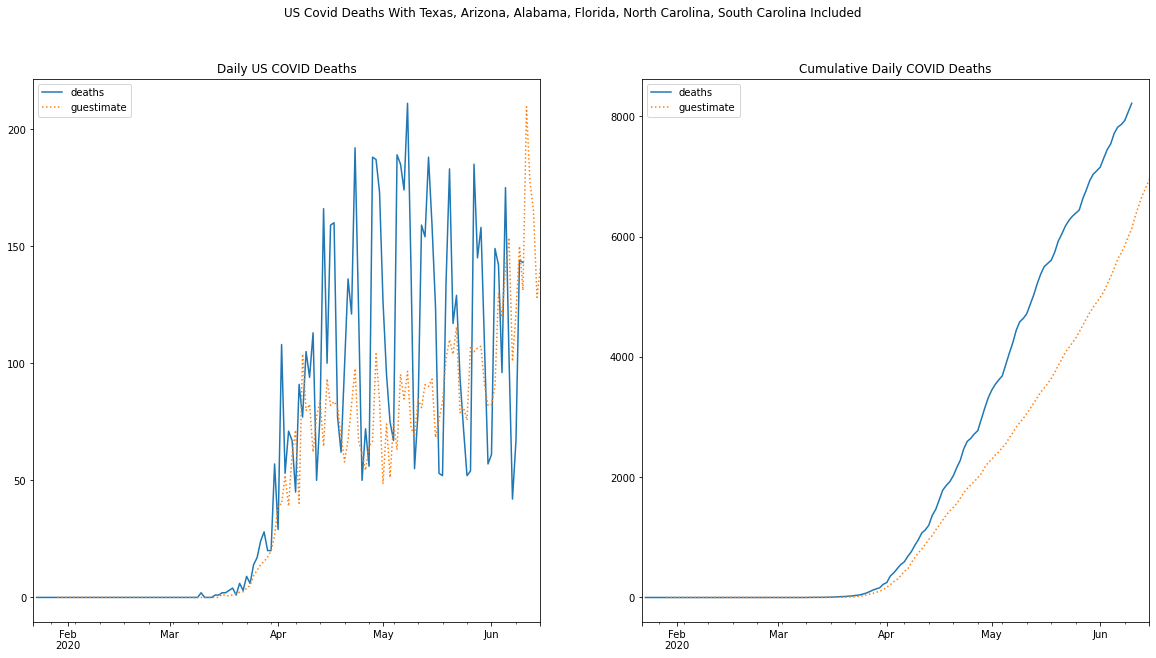

deaths   guestimate
2020-06-10  8216.0  6128.597858
2020-06-11     NaN  6338.089770
2020-06-12     NaN  6515.384717
2020-06-13     NaN  6680.545838
2020-06-14     NaN  6808.684682
2020-06-15     NaN  6950.227170

In [0]:

#LOAD US DAILY DATA from JH
tmp = US_daily.copy()
df = pd.DataFrame()

tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

# establish states to be included
include=["Texas", "Arizona", "Alabama", "Florida","North Carolina", "South Carolina"]

include_str = prep_list_of_str(include)
if include_str == '':
  include_str = "No States Included"
else:
  include_str = include_str + " Included"

# create targets list eliminating all those in 
targets = [x for x in tmp[(tmp["Country/Region"] == "US")]["Province/State"].unique() if x in include]

# interesction with targets creates a dataframe included states
tmp = tmp[tmp["Province/State"].isin(targets)]
#print(tmp["Province/State"].isin(targets))
#print(tmp)

#create new dataframe rows (for today's daily)
df.loc[yesterday_csv[:-4], "deaths"] = tmp[(tmp["Country/Region"] == "US")]["Deaths"].sum()
df.loc[yesterday_csv[:-4], "confirmed"] = tmp[tmp["Country/Region"] == "US"]["Confirmed"].sum()

# iterate over all daily files - summarize death/confirmed by date
for x in os.listdir("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"):
  if not x.endswith("2020.csv"):
      continue
  try:
    tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
  except:
    pass
  tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

  tmp = tmp[tmp["Province/State"].isin(targets)]

  df.loc[x[:-4], "deaths"] = tmp[tmp["Country/Region"] == "US"]["Deaths"].sum()
  df.loc[x[:-4], "confirmed"] = tmp[tmp["Country/Region"] == "US"]["Confirmed"].sum()

#print("XXX",x[:-4])
#print(df.shape)
#print(df)

# sort index (the date, x[:4]) and cast that index to datetime data type
df.sort_index(inplace=True)
df.index = pd.to_datetime(df.index)
#print(df)

# copy to tmp
tmp = df.copy()
my_range = 30

# turn corr_tmp in daily deltas
corr_tmp = (tmp.diff())
#print('tmp.diff',corr_tmp)

#creates shifted correlation data frame indexed by i of deaths/confirmed
for i in range(my_range):
  corr_tmp["deaths_lag_{}".format(i)] = corr_tmp["deaths"].shift(i).fillna(0)
  corr_tmp["confirmed_lag_{}".format(i)] = corr_tmp["confirmed"].shift(i).fillna(0)
#print(corr_tmp.to_markdown())

#run correlation on df
corr_df = corr_tmp.corr()
#print(corr_df)

death_corrs = pd.DataFrame()
confirmed_corrs = pd.DataFrame()

#creates 
for i in range(my_range):
  death_corrs.loc()[i, "deaths"] = corr_df.loc()["deaths", "deaths_lag_{}".format(i)]
  death_corrs.loc()[i, "confirmed"] = corr_df.loc()["deaths", "confirmed_lag_{}".format(i)]
#print(death_corrs.to_markdown())

#obtain the largest confirmed correlation lag off shifted df -> changed to deaths instead of confirmed
max_correlation_days_lag = death_corrs[["confirmed"]].idxmax()[0]
print('Days Lag: ', max_correlation_days_lag)

daily_deaths = tmp.diff()
daily_deaths.index = pd.to_datetime(daily_deaths.index)
#print(daily_deaths.to_markdown())

mean_ratio = np.mean([((daily_deaths["deaths"][-i])/(daily_deaths["confirmed"][-i - max_correlation_days_lag+1])) for i in range(1,21)])
#print('mean-ratio',mean_ratio)

daily_deaths["guestimate"] =  mean_ratio*daily_deaths["confirmed"].shift(max_correlation_days_lag)
#print(daily_deaths.to_markdown())

daily_deaths["diff_ratio"] = (daily_deaths["deaths"]-daily_deaths["guestimate"])/daily_deaths["deaths"]
#print(daily_deaths.to_markdown())

startForecast = daily_deaths.index.max()
cvals = daily_deaths.confirmed[-max_correlation_days_lag:]
for forecast in range(1,max_correlation_days_lag):
  daily_deaths.at[startForecast + dt.timedelta(days=forecast), "guestimate"] = mean_ratio * cvals[forecast-max_correlation_days_lag-1]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20,10), facecolor="w")
daily_deaths[["deaths", "guestimate"]].plot(ax=ax1, style=["-", ":"], title="Daily US COVID Deaths")

#(mean_ratio * daily_deaths["confirmed"]).shift(7).plot(ax=ax1)

daily_deaths[["deaths", "guestimate"]].cumsum().plot(ax=ax2, style=["-", ":"], title="Cumulative Daily COVID Deaths")

fig.suptitle("US Covid Deaths With {}".format(include_str))

plt.show()

display(daily_deaths[["deaths","guestimate"]].cumsum()[-max_correlation_days_lag:])

#US Data - looking at national and by-state doubling times

this generates linear and log graphs of US death rates (need to run the code in the next block that defins run() first)

# Just lookin at Last Week

2020-06-10 16:06:30.488827
06-09-2020.csv


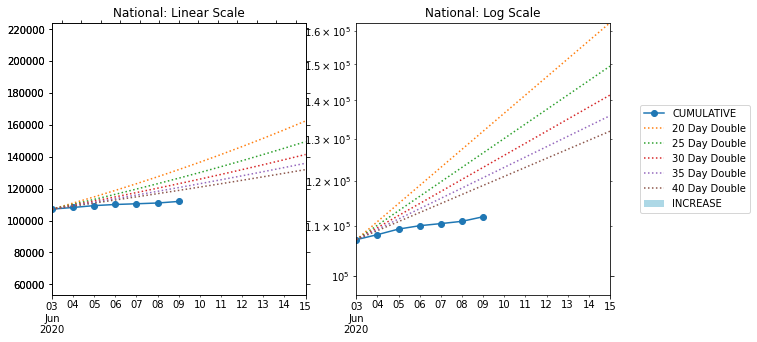

In [0]:
"""

K, so this got a bit long but I'm combining it with the function call, just setting the DEATH_CUTOFF to
1000 as threshhold here which gets used below

"""
DEATH_CUTOFF = 1000

import matplotlib.pyplot as plt
import datetime as dt, numpy as np, pandas as pd, os

us_deaths = pd.DataFrame()
state_deaths = pd.DataFrame()

# Get Yesterday's data drop
print(dt.datetime.now())
xx = dt.datetime.now() - timedelta(days=1)
print(xx.strftime("%m-%d-%Y") + ".csv")
x = xx.strftime("%m-%d-%Y") + ".csv"

# can override with a specific data drop date
# x = "06-09-2020.csv"


tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

us_deaths.loc[x[:-4], "CUMULATIVE"] = tmp[tmp["Country/Region"] == "US"]["Deaths"].sum()
state_deaths[x[:-4]] =tmp[tmp["Country/Region"] == "US"].groupby('Province/State').sum()["Deaths"]

for x in os.listdir("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"):
    if not x.endswith("2020.csv"):
        continue
    try:
      tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
    except:
      pass
    tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

    us_deaths.loc[x[:-4], "CUMULATIVE"] = tmp[tmp["Country/Region"] == "US"]["Deaths"].sum()
    state_deaths[x[:-4]] =tmp[tmp["Country/Region"] == "US"].groupby('Province/State').sum()["Deaths"]

us_deaths.sort_index(inplace=True)
us_deaths.index = pd.to_datetime(us_deaths.index)

state_deaths = state_deaths[sorted([x for x in state_deaths.columns])].fillna(0)

td = us_deaths[-7:].T

testing = td.copy()

#Set up to go a few days into the future
maxDate = td.columns.max()
try:
  for i in range(1,7):
      td[str(maxDate + dt.timedelta(days=i))] = np.NaN
except:
  pass
td = td.T

td.index = pd.to_datetime(td.index)

td["day"] = range(len(td))


"""
Figure out math for exponents for exponential growth
"""

days = pd.DataFrame()
days["d"] = [20, 25,30,35, 40]
#daily rate to double every x days
days["r"] = days.d.apply(lambda x: 2**(1/(x)))

#Give value of expected value along each exponential for doubling period
for i in range(len(days)):
  td["{} Day Double".format(days["d"][i])] = td["day"].apply(lambda x: td.CUMULATIVE[0] *(days.r[i]**x))

#set up plots
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,5), facecolor="w")


styles = ["o-"] + [":" for i in range(len(days))]
td[[x for x in td.columns if x != "day"]].plot(style=styles, title="National: Linear Scale", ax = ax1)
ax1Max = td["CUMULATIVE"].max()
ax1Min = td["CUMULATIVE"].min()
total_max = td.max().max()

td[[x for x in td.columns if x != "day"]].plot(style=styles, title="National: Log Scale", ax = ax2)
#fulocs, fulabels = ax2.yticks()

ax1.set_ylim((ax1Min/2, ax1Max*2))
ax1.yaxis.tick_left()
ax1.yaxis.set_ticks_position('both')

ax2.set_ylim((ax1Min*.9, total_max))
#ax2.yaxis.tick_right()
ax2.yaxis.set_ticks_position('both')

#shinanigans to make these plot together with bar

td = td.diff()[["CUMULATIVE"]].rename(columns={"CUMULATIVE":"INCREASE"})
td.index = pd.to_datetime(td.index)
#td.loc()[td.index[0], "ACTUAL CHANGE"] = 0
td.fillna(0, inplace=True)


ax1tmp = ax1.twiny()
td.plot(kind='bar', color="lightblue", ax=ax1tmp)
ax1tmp.set_xticklabels([])


#ax2.set_ylim(20)
ax2.set_yscale("log")
#ax2tmp = ax2.twiny()
#td.plot(kind='bar', color="lightblue", ax=ax2tmp)
#ax2tmp.set_xticklabels([])
#ax2tmp.yaxis.set_ticks_position("none")

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax1tmp.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.1, 0.5))

#ax2tmp.get_legend().remove()

#shinanigans done

ax1tmp.get_legend().remove()
ax1.get_legend().remove()

#US Data - Moving Weekly Change

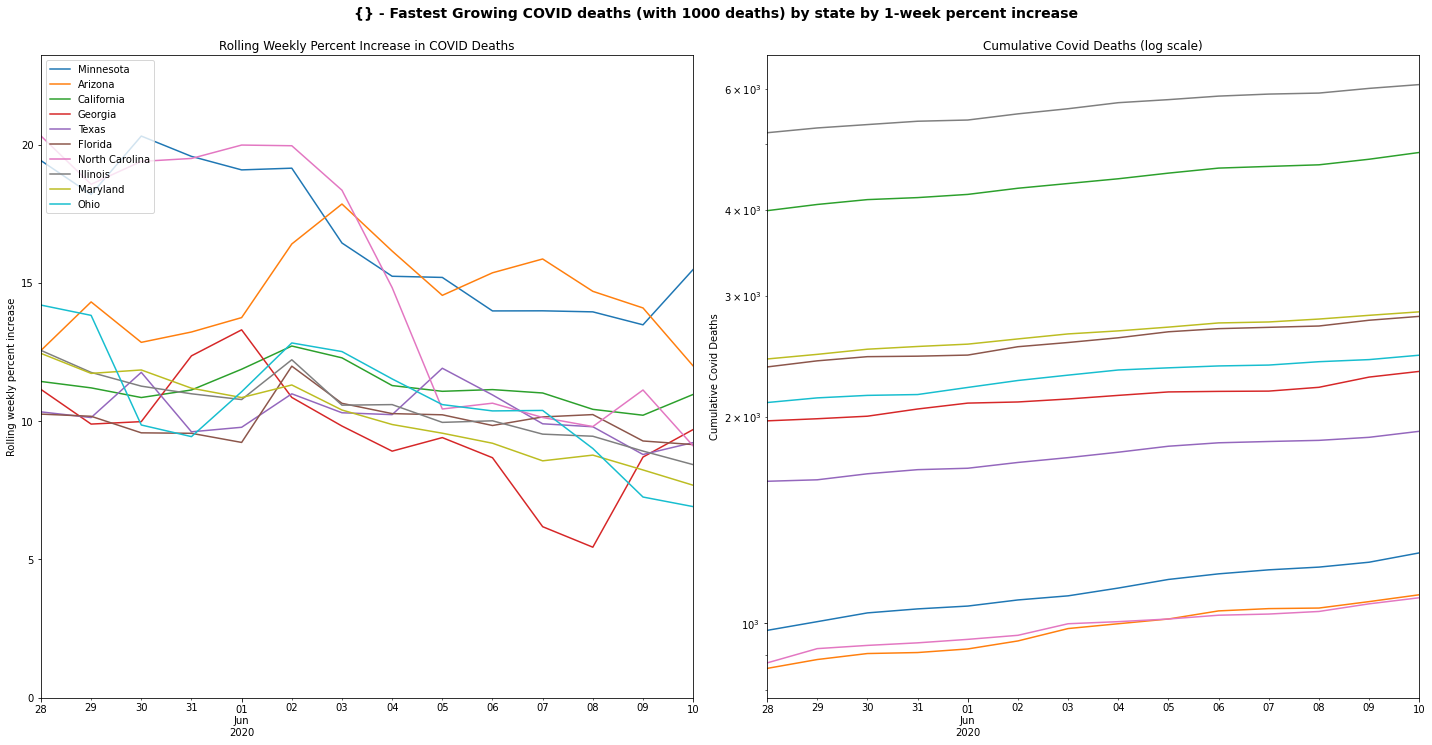

In [0]:
# establishes metric for 'at least xx deaths"
death_cutoff = 1000


us_deaths = pd.DataFrame()
state_deaths = pd.DataFrame()

tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + yesterday_csv)
tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

us_deaths.loc[x[:-4], "CUMULATIVE"] = tmp[tmp["Country/Region"] == "US"]["Deaths"].sum()
state_deaths[x[:-4]] =tmp[tmp["Country/Region"] == "US"].groupby('Province/State').sum()["Deaths"]

for x in os.listdir("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"):
    if not x.endswith("2020.csv"):
        continue
    try:
      tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
    except:
      pass
    tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

    us_deaths.loc[x[:-4], "CUMULATIVE"] = tmp[tmp["Country/Region"] == "US"]["Deaths"].sum()
    state_deaths[x[:-4]] =tmp[tmp["Country/Region"] == "US"].groupby('Province/State').sum()["Deaths"]

us_deaths.sort_index(inplace=True)
us_deaths.index = pd.to_datetime(us_deaths.index)

state_deaths = state_deaths[sorted([x for x in state_deaths.columns])].fillna(0)
tmp = state_deaths.T

#print(us_deaths.to_markdown())
#print(state_deaths.to_markdown())

fig, [ax, ax1] = plt.subplots(nrows=1, ncols=2, figsize=(20,10), facecolor="w")

"""
This section goes and pulls states with more deaths than the cutoff for today
"""
weekly_increases = []
state_dfs = {}
for state in tmp.columns:
  if tmp[[state]][state].max() < death_cutoff: #only checking states with at least date_cutoff deaths; otherwise just noise
    continue
  state_dfs[state] = tmp[[state]]
  state_dfs[state].index = pd.to_datetime(state_dfs[state].index)
  state_dfs[state]["WeekPrior"] = state_dfs[state][state].shift(7)
  state_dfs[state]["WeekPercentIncrease"] = 100*(state_dfs[state][state] - state_dfs[state]["WeekPrior"])/state_dfs[state]["WeekPrior"]
  state_dfs[state].replace(np.inf, 0, inplace=True)
  state_dfs[state].fillna(0, inplace=True)
  weekly_increases.append((state_dfs[state]["WeekPercentIncrease"][-1], state))
  

max_percent_increase = -1
for _, state in sorted(weekly_increases, reverse=True)[:10]:
  state_dfs[state][-14:]["WeekPercentIncrease"].plot(ax=ax, label=state)
  state_dfs[state][-14:][state].plot(ax=ax1, label=state, logy=True)

  if state_dfs[state][-14:]["WeekPercentIncrease"][-1] > max_percent_increase:
    max_percent_increase = state_dfs[state][-14:]["WeekPercentIncrease"][-1]

ax.set_ylim(0, max_percent_increase*1.5)

ax.legend(loc="upper left")

ax.set_ylabel("Rolling weekly percent increase")
ax1.set_ylabel("Cumulative Covid Deaths")

ax.set_title("Rolling Weekly Percent Increase in COVID Deaths")
ax1.set_title("Cumulative Covid Deaths (log scale)")

fig.suptitle("{} - Fastest Growing COVID deaths (with " + str(death_cutoff) + " deaths) by state by 1-week percent increase".format(us_deaths.index.max().strftime("%m-%d-%Y")), y=1.03, fontsize=14, weight="bold")
fig.tight_layout()

plt.show()



In [0]:
max_deaths

30458.0

Did I screw something up? let me know at brockman@email.arizona.edu

2020-06-10 16:06:37.434772
06-09-2020.csv


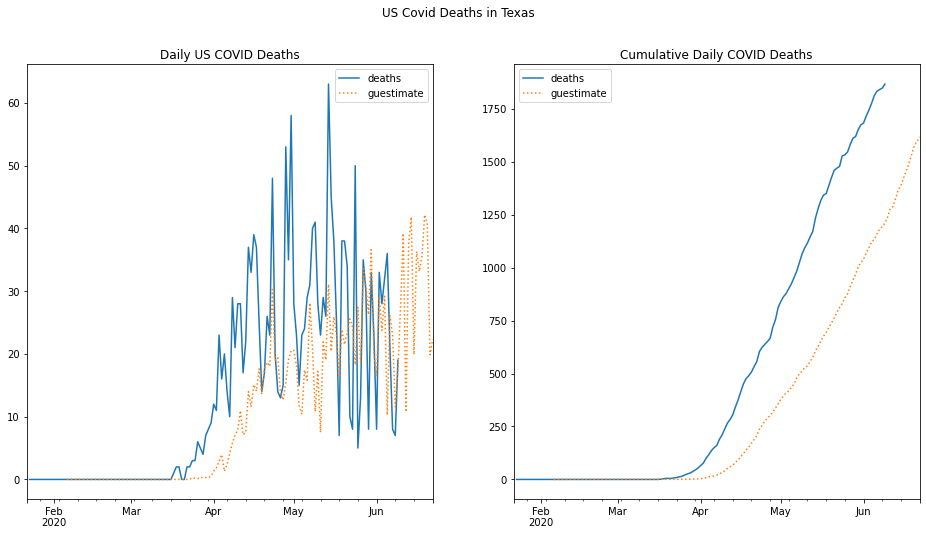

deaths   guestimate
2020-06-09  1867.0  1210.804528
2020-06-10     NaN  1238.562270
2020-06-11     NaN  1277.765848
2020-06-12     NaN  1288.471197
2020-06-13     NaN  1326.003387
2020-06-14     NaN  1367.830410
2020-06-15     NaN  1387.738973
2020-06-16     NaN  1424.065225
2020-06-17     NaN  1457.217954
2020-06-18     NaN  1492.719090
2020-06-19     NaN  1534.884622
2020-06-20     NaN  1575.548021
2020-06-21     NaN  1595.393113
2020-06-22     NaN  1617.713553

In [0]:
import os

df = pd.DataFrame()

# Get Yesterday's data drop
print(dt.datetime.now())
xx = dt.datetime.now() - timedelta(days=1)
print(xx.strftime("%m-%d-%Y") + ".csv")
x = xx.strftime("%m-%d-%Y") + ".csv"

# can override with a specific data drop date
# x = "06-09-2020.csv"


tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

targets = ["Texas"]

tmp = tmp[tmp["Province/State"].isin(targets)]

df.loc[x[:-4], "deaths"] = tmp[(tmp["Country/Region"] == "US")]["Deaths"].sum()
df.loc[x[:-4], "confirmed"] = tmp[tmp["Country/Region"] == "US"]["Confirmed"].sum()


for x in os.listdir("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"):
  if not x.endswith("2020.csv"):
      continue
  try:
    tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
  except:
    pass
  tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

  tmp = tmp[tmp["Province/State"].isin(targets)]

  df.loc[x[:-4], "deaths"] = tmp[tmp["Country/Region"] == "US"]["Deaths"].sum()
  df.loc[x[:-4], "confirmed"] = tmp[tmp["Country/Region"] == "US"]["Confirmed"].sum()

df.sort_index(inplace=True)
df.index = pd.to_datetime(df.index)

tmp = df.copy()


my_range = 30

corr_tmp = (tmp.diff())
for i in range(my_range):
  corr_tmp["deaths_lag_{}".format(i)] = corr_tmp["deaths"].shift(i).fillna(0)
  corr_tmp["confirmed_lag_{}".format(i)] = corr_tmp["confirmed"].shift(i).fillna(0)


corr_df = corr_tmp.corr()
death_corrs = pd.DataFrame()
confirmed_corrs = pd.DataFrame()

for i in range(my_range):
  death_corrs.loc()[i, "deaths"] = corr_df.loc()["deaths", "deaths_lag_{}".format(i)]
  death_corrs.loc()[i, "confirmed"] = corr_df.loc()["deaths", "confirmed_lag_{}".format(i)]

max_correlation_days_lag = death_corrs[["confirmed"]][2:].idxmax()[0]


daily_deaths = tmp.diff()
daily_deaths.index = pd.to_datetime(daily_deaths.index)

mean_ratio = np.mean([((daily_deaths["deaths"][-i])/(daily_deaths["confirmed"][-i - max_correlation_days_lag+1])) for i in range(1,21)])
daily_deaths["guestimate"] =  mean_ratio*daily_deaths["confirmed"].shift(max_correlation_days_lag)
startForecast = daily_deaths.index.max()
cvals = daily_deaths.confirmed[-max_correlation_days_lag:]
for forecast in range(1,max_correlation_days_lag):
  daily_deaths.at[startForecast + dt.timedelta(days=forecast), "guestimate"] = mean_ratio * cvals[forecast-max_correlation_days_lag-1]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16,8), facecolor="w")
daily_deaths[["deaths", "guestimate"]].plot(ax=ax1, style=["-", ":"], title="Daily US COVID Deaths")

#(mean_ratio * daily_deaths["confirmed"]).shift(7).plot(ax=ax1)

daily_deaths[["deaths", "guestimate"]].cumsum().plot(ax=ax2, style=["-", ":"], title="Cumulative Daily COVID Deaths")

fig.suptitle("US Covid Deaths in {}".format(";".join(targets)))

plt.show()

display(daily_deaths[["deaths","guestimate"]].cumsum()[-max_correlation_days_lag:])

In [0]:
print("Days Lag:{}\nRatio:{}".format(max_correlation_days_lag,mean_ratio))


Days Lag:14
Ratio:0.021156815102819727


2020-06-10 16:06:40.011780
06-09-2020.csv


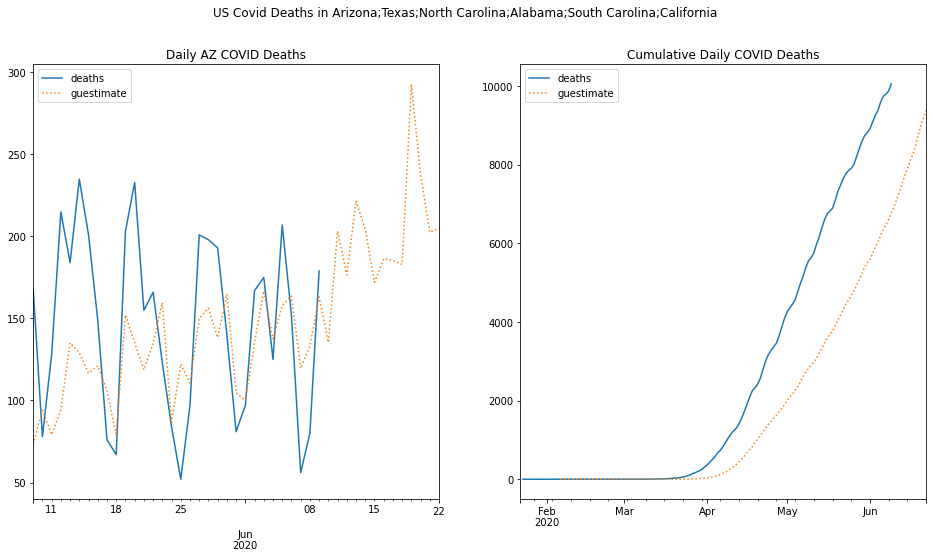

deaths   guestimate
2020-06-09  10053.0  6774.201579
2020-06-10      NaN  6909.654160
2020-06-11      NaN  7112.938876
2020-06-12      NaN  7289.520170
2020-06-13      NaN  7511.282566
2020-06-14      NaN  7715.776950
2020-06-15      NaN  7887.791747
2020-06-16      NaN  8074.322561
2020-06-17      NaN  8259.704190
2020-06-18      NaN  8442.606000
2020-06-19      NaN  8735.617844
2020-06-20      NaN  8973.559550
2020-06-21      NaN  9176.027740
2020-06-22      NaN  9380.945508

In [0]:
import os

df = pd.DataFrame()
# Get Yesterday's data drop
print(dt.datetime.now())
xx = dt.datetime.now() - timedelta(days=1)
print(xx.strftime("%m-%d-%Y") + ".csv")
x = xx.strftime("%m-%d-%Y") + ".csv"

# can override with a specific data drop date
# x = "06-09-2020.csv"

tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

targets = ["Arizona", "Texas", "North Carolina", 'Alabama', 'South Carolina', 'California']

tmp = tmp[tmp["Province/State"].isin(targets)]

df.loc[x[:-4], "deaths"] = tmp[(tmp["Country/Region"] == "US")]["Deaths"].sum()
df.loc[x[:-4], "confirmed"] = tmp[tmp["Country/Region"] == "US"]["Confirmed"].sum()


for x in os.listdir("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"):
  if not x.endswith("2020.csv"):
      continue
  try:
    tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
  except:
    pass
  tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

  tmp = tmp[tmp["Province/State"].isin(targets)]

  df.loc[x[:-4], "deaths"] = tmp[tmp["Country/Region"] == "US"]["Deaths"].sum()
  df.loc[x[:-4], "confirmed"] = tmp[tmp["Country/Region"] == "US"]["Confirmed"].sum()

df.sort_index(inplace=True)
df.index = pd.to_datetime(df.index)

tmp = df.copy()


my_range = 30

corr_tmp = (tmp.diff())
for i in range(my_range):
  corr_tmp["deaths_lag_{}".format(i)] = corr_tmp["deaths"].shift(i).fillna(0)
  corr_tmp["confirmed_lag_{}".format(i)] = corr_tmp["confirmed"].shift(i).fillna(0)


corr_df = corr_tmp.corr()
death_corrs = pd.DataFrame()
confirmed_corrs = pd.DataFrame()

for i in range(my_range):
  death_corrs.loc()[i, "deaths"] = corr_df.loc()["deaths", "deaths_lag_{}".format(i)]
  death_corrs.loc()[i, "confirmed"] = corr_df.loc()["deaths", "confirmed_lag_{}".format(i)]

max_correlation_days_lag = death_corrs[["confirmed"]][2:].idxmax()[0]


daily_deaths = tmp.diff()
daily_deaths.index = pd.to_datetime(daily_deaths.index)

mean_ratio = np.mean([((daily_deaths["deaths"][-i])/(daily_deaths["confirmed"][-i - max_correlation_days_lag+1])) for i in range(1,21)])
daily_deaths["guestimate"] =  mean_ratio*daily_deaths["confirmed"].shift(max_correlation_days_lag)
startForecast = daily_deaths.index.max()
cvals = daily_deaths.confirmed[-max_correlation_days_lag:]
for forecast in range(1,max_correlation_days_lag):
  daily_deaths.at[startForecast + dt.timedelta(days=forecast), "guestimate"] = mean_ratio * cvals[forecast-max_correlation_days_lag-1]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16,8), facecolor="w")
daily_deaths[["deaths", "guestimate"]][-45:].plot(ax=ax1, style=["-", ":"], title="Daily AZ COVID Deaths")

#(mean_ratio * daily_deaths["confirmed"]).shift(7).plot(ax=ax1)

daily_deaths[["deaths", "guestimate"]].cumsum().plot(ax=ax2, style=["-", ":"], title="Cumulative Daily COVID Deaths")

fig.suptitle("US Covid Deaths in {}".format(";".join(targets)))

plt.show()

display(daily_deaths[["deaths","guestimate"]].cumsum()[-max_correlation_days_lag:])

Colorado's wierd, it doesn't like this method; I take that back, it's settled now an working-ish

2020-06-10 16:06:42.548333
06-09-2020.csv


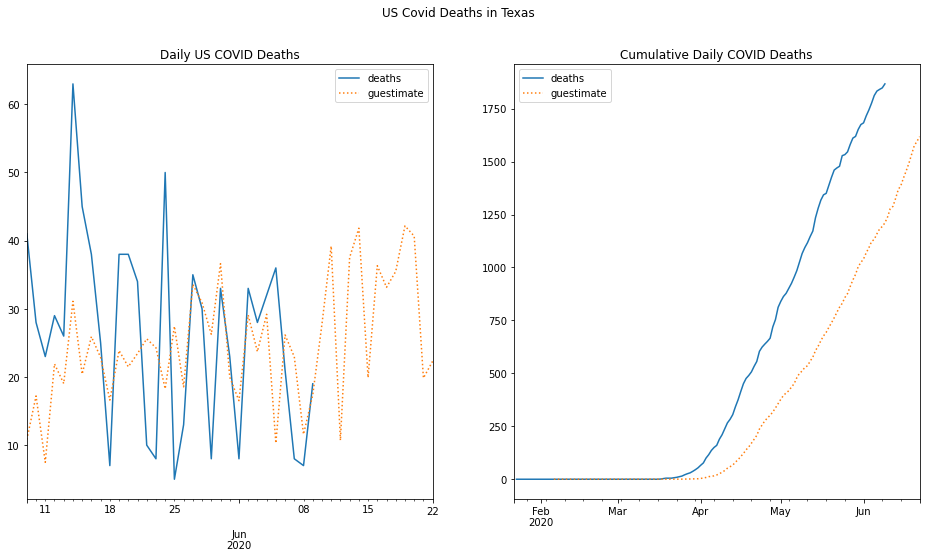

deaths   guestimate
2020-06-09  1867.0  1210.804528
2020-06-10     NaN  1238.562270
2020-06-11     NaN  1277.765848
2020-06-12     NaN  1288.471197
2020-06-13     NaN  1326.003387
2020-06-14     NaN  1367.830410
2020-06-15     NaN  1387.738973
2020-06-16     NaN  1424.065225
2020-06-17     NaN  1457.217954
2020-06-18     NaN  1492.719090
2020-06-19     NaN  1534.884622
2020-06-20     NaN  1575.548021
2020-06-21     NaN  1595.393113
2020-06-22     NaN  1617.713553

In [0]:
import os

df = pd.DataFrame()
# Get Yesterday's data drop
print(dt.datetime.now())
xx = dt.datetime.now() - timedelta(days=1)
print(xx.strftime("%m-%d-%Y") + ".csv")
x = xx.strftime("%m-%d-%Y") + ".csv"

# can override with a specific data drop date
# x = "06-09-2020.csv"



tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

targets = ["Texas"]

tmp = tmp[tmp["Province/State"].isin(targets)]

df.loc[x[:-4], "deaths"] = tmp[(tmp["Country/Region"] == "US")]["Deaths"].sum()
df.loc[x[:-4], "confirmed"] = tmp[tmp["Country/Region"] == "US"]["Confirmed"].sum()


for x in os.listdir("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"):
  if not x.endswith("2020.csv"):
      continue
  try:
    tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
  except:
    pass
  tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

  tmp = tmp[tmp["Province/State"].isin(targets)]

  df.loc[x[:-4], "deaths"] = tmp[tmp["Country/Region"] == "US"]["Deaths"].sum()
  df.loc[x[:-4], "confirmed"] = tmp[tmp["Country/Region"] == "US"]["Confirmed"].sum()

df.sort_index(inplace=True)
df.index = pd.to_datetime(df.index)

tmp = df.copy()


my_range = 30

corr_tmp = (tmp.diff())
for i in range(my_range):
  corr_tmp["deaths_lag_{}".format(i)] = corr_tmp["deaths"].shift(i).fillna(0)
  corr_tmp["confirmed_lag_{}".format(i)] = corr_tmp["confirmed"].shift(i).fillna(0)


corr_df = corr_tmp.corr()
death_corrs = pd.DataFrame()
confirmed_corrs = pd.DataFrame()

for i in range(my_range):
  death_corrs.loc()[i, "deaths"] = corr_df.loc()["deaths", "deaths_lag_{}".format(i)]
  death_corrs.loc()[i, "confirmed"] = corr_df.loc()["deaths", "confirmed_lag_{}".format(i)]

max_correlation_days_lag = death_corrs[["confirmed"]][2:].idxmax()[0]


daily_deaths = tmp.diff()
daily_deaths.index = pd.to_datetime(daily_deaths.index)

mean_ratio = np.mean([((daily_deaths["deaths"][-i])/(daily_deaths["confirmed"][-i - max_correlation_days_lag+1])) for i in range(1,21)])
daily_deaths["guestimate"] =  mean_ratio*daily_deaths["confirmed"].shift(max_correlation_days_lag)
startForecast = daily_deaths.index.max()
cvals = daily_deaths.confirmed[-max_correlation_days_lag:]
for forecast in range(1,max_correlation_days_lag):
  daily_deaths.at[startForecast + dt.timedelta(days=forecast), "guestimate"] = mean_ratio * cvals[forecast-max_correlation_days_lag-1]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16,8), facecolor="w")
daily_deaths[["deaths", "guestimate"]][-45:].plot(ax=ax1, style=["-", ":"], title="Daily US COVID Deaths")

#(mean_ratio * daily_deaths["confirmed"]).shift(7).plot(ax=ax1)

daily_deaths[["deaths", "guestimate"]].cumsum().plot(ax=ax2, style=["-", ":"], title="Cumulative Daily COVID Deaths")

fig.suptitle("US Covid Deaths in {}".format(";".join(targets)))

plt.show()

display(daily_deaths[["deaths","guestimate"]].cumsum()[-max_correlation_days_lag:])

2020-06-10 16:06:45.059329
06-09-2020.csv


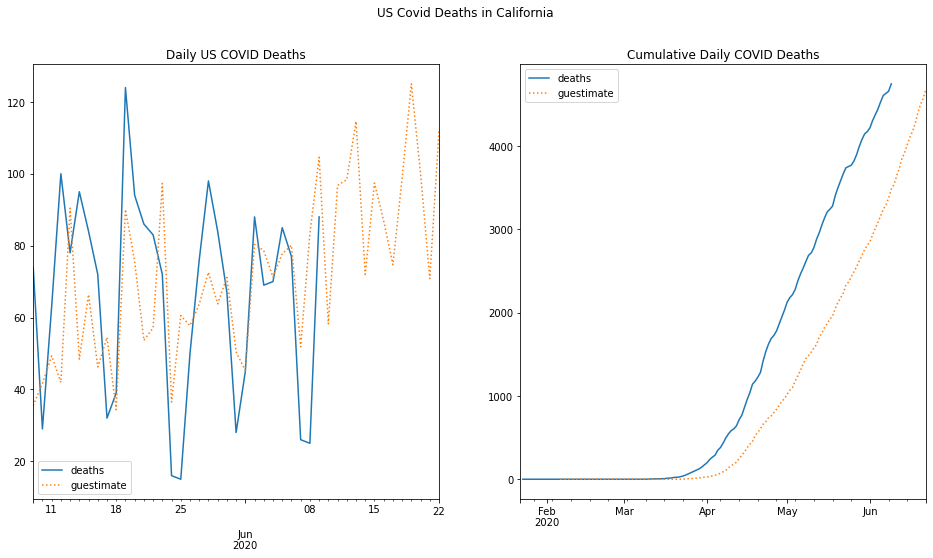

deaths   guestimate
2020-06-09  4745.0  3480.084993
2020-06-10     NaN  3538.315762
2020-06-11     NaN  3635.063574
2020-06-12     NaN  3733.422099
2020-06-13     NaN  3848.027814
2020-06-14     NaN  3920.019672
2020-06-15     NaN  4017.432779
2020-06-16     NaN  4104.341237
2020-06-17     NaN  4179.029288
2020-06-18     NaN  4277.772983
2020-06-19     NaN  4402.778300
2020-06-20     NaN  4502.747538
2020-06-21     NaN  4573.548869
2020-06-22     NaN  4685.633468

In [0]:
import os

df = pd.DataFrame()

# Get Yesterday's data drop
print(dt.datetime.now())
xx = dt.datetime.now() - timedelta(days=1)
print(xx.strftime("%m-%d-%Y") + ".csv")
x = xx.strftime("%m-%d-%Y") + ".csv"

# can override with a specific data drop date
# x = "06-09-2020.csv"



tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

targets = ["California"]

tmp = tmp[tmp["Province/State"].isin(targets)]

df.loc[x[:-4], "deaths"] = tmp[(tmp["Country/Region"] == "US")]["Deaths"].sum()
df.loc[x[:-4], "confirmed"] = tmp[tmp["Country/Region"] == "US"]["Confirmed"].sum()


for x in os.listdir("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"):
  if not x.endswith("2020.csv"):
      continue
  try:
    tmp = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/" + x)
  except:
    pass
  tmp.rename(columns={"Country_Region":"Country/Region", "Province_State":"Province/State"}, inplace=True)

  tmp = tmp[tmp["Province/State"].isin(targets)]

  df.loc[x[:-4], "deaths"] = tmp[tmp["Country/Region"] == "US"]["Deaths"].sum()
  df.loc[x[:-4], "confirmed"] = tmp[tmp["Country/Region"] == "US"]["Confirmed"].sum()

df.sort_index(inplace=True)
df.index = pd.to_datetime(df.index)

tmp = df.copy()


my_range = 30

corr_tmp = (tmp.diff())
for i in range(my_range):
  corr_tmp["deaths_lag_{}".format(i)] = corr_tmp["deaths"].shift(i).fillna(0)
  corr_tmp["confirmed_lag_{}".format(i)] = corr_tmp["confirmed"].shift(i).fillna(0)


corr_df = corr_tmp.corr()
death_corrs = pd.DataFrame()
confirmed_corrs = pd.DataFrame()

for i in range(my_range):
  death_corrs.loc()[i, "deaths"] = corr_df.loc()["deaths", "deaths_lag_{}".format(i)]
  death_corrs.loc()[i, "confirmed"] = corr_df.loc()["deaths", "confirmed_lag_{}".format(i)]

max_correlation_days_lag = death_corrs[["confirmed"]][2:].idxmax()[0]


daily_deaths = tmp.diff()
daily_deaths.index = pd.to_datetime(daily_deaths.index)


ratios = [((daily_deaths["deaths"][-i])/(daily_deaths["confirmed"][-i - max_correlation_days_lag+1])) for i in range(1,21)]
mean_ratio = np.mean([ratio for ratio in ratios[-14:] if ratio != np.inf])

daily_deaths["guestimate"] =  mean_ratio*daily_deaths["confirmed"].shift(max_correlation_days_lag)
startForecast = daily_deaths.index.max()
cvals = daily_deaths.confirmed[-max_correlation_days_lag:]
for forecast in range(1,max_correlation_days_lag):
  daily_deaths.at[startForecast + dt.timedelta(days=forecast), "guestimate"] = mean_ratio * cvals[forecast-max_correlation_days_lag-1]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16,8), facecolor="w")
daily_deaths[["deaths", "guestimate"]][-45:].plot(ax=ax1, style=["-", ":"], title="Daily US COVID Deaths")

#(mean_ratio * daily_deaths["confirmed"]).shift(7).plot(ax=ax1)

daily_deaths[["deaths", "guestimate"]].cumsum().plot(ax=ax2, style=["-", ":"], title="Cumulative Daily COVID Deaths")

fig.suptitle("US Covid Deaths in {}".format(";".join(targets)))

plt.show()

display(daily_deaths[["deaths","guestimate"]].cumsum()[-max_correlation_days_lag:])

# What about the UK?

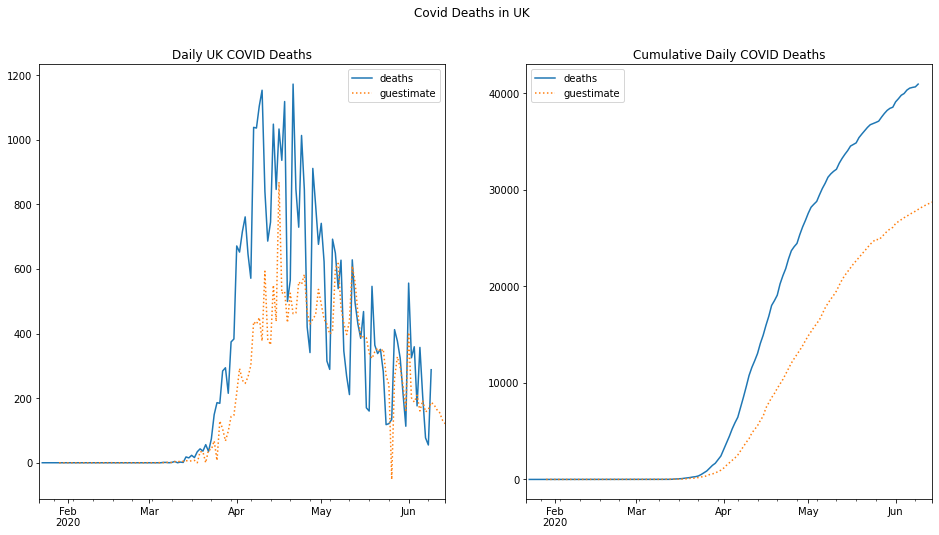

deaths    guestimate
2020-06-09  40968.0  27982.027703
2020-06-10      NaN  28161.995308
2020-06-11      NaN  28326.642287
2020-06-12      NaN  28481.838231
2020-06-13      NaN  28613.854268
2020-06-14      NaN  28734.529063

In [0]:
deaths = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
confirmed = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

deaths = deaths.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()
confirmed = confirmed.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()

deaths = deaths.T
confirmed = confirmed.T

nations = {}
for nation in deaths.columns:
  nations[nation] = deaths[[nation]]
  nations[nation].columns = ["deaths"]
  nations[nation]["confirmed"] = confirmed[nation]


tmp = nations["United Kingdom"][["deaths", "confirmed"]]
tmp.index = pd.to_datetime(tmp.index)

my_range = 30

corr_tmp = (tmp.diff())
for i in range(my_range):
  corr_tmp["deaths_lag_{}".format(i)] = corr_tmp["deaths"].shift(i).fillna(0)
  corr_tmp["confirmed_lag_{}".format(i)] = corr_tmp["confirmed"].shift(i).fillna(0)


corr_df = corr_tmp.corr()
death_corrs = pd.DataFrame()
confirmed_corrs = pd.DataFrame()

for i in range(my_range):
  death_corrs.loc()[i, "deaths"] = corr_df.loc()["deaths", "deaths_lag_{}".format(i)]
  death_corrs.loc()[i, "confirmed"] = corr_df.loc()["deaths", "confirmed_lag_{}".format(i)]

max_correlation_days_lag = death_corrs[["confirmed"]][2:].idxmax()[0]

daily_deaths = tmp.diff()
daily_deaths.index = pd.to_datetime(daily_deaths.index)

mean_ratio = np.mean([((daily_deaths["deaths"][-i])/(daily_deaths["confirmed"][-i - max_correlation_days_lag+1])) for i in range(1,21)])
daily_deaths["guestimate"] =  mean_ratio*daily_deaths["confirmed"].shift(max_correlation_days_lag)
startForecast = daily_deaths.index.max()
cvals = daily_deaths.confirmed[-max_correlation_days_lag:]
for forecast in range(1,max_correlation_days_lag):
  daily_deaths.at[startForecast + dt.timedelta(days=forecast), "guestimate"] = mean_ratio * cvals[forecast-max_correlation_days_lag-1]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16,8), facecolor="w")
daily_deaths[["deaths", "guestimate"]].plot(ax=ax1, style=["-", ":"], title="Daily UK COVID Deaths")

#(mean_ratio * daily_deaths["confirmed"]).shift(7).plot(ax=ax1)

daily_deaths[["deaths", "guestimate"]].cumsum().plot(ax=ax2, style=["-", ":"], title="Cumulative Daily COVID Deaths")

fig.suptitle("Covid Deaths in UK")

plt.show()

display(daily_deaths[["deaths","guestimate"]].cumsum()[-max_correlation_days_lag:])

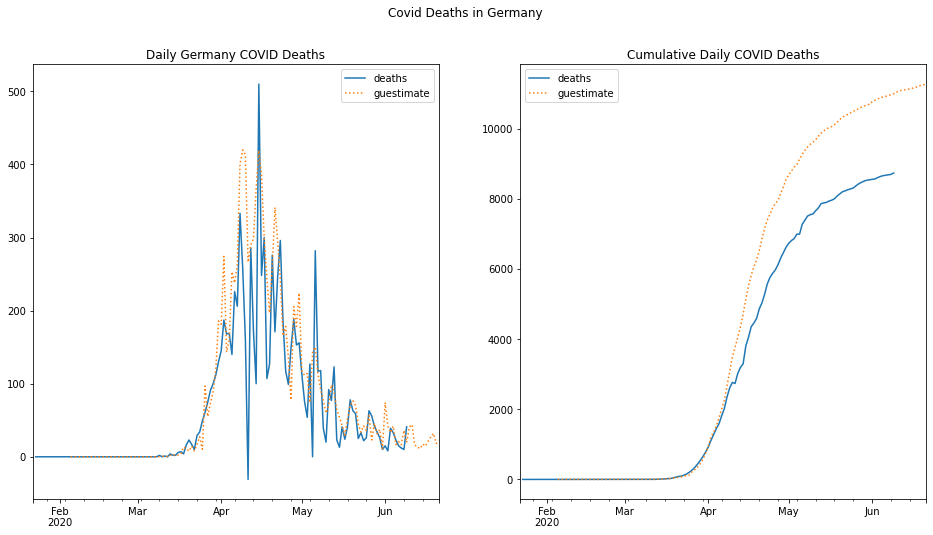

deaths    guestimate
2020-06-09  8736.0  10993.093115
2020-06-10     NaN  11033.789434
2020-06-11     NaN  11077.755992
2020-06-12     NaN  11093.925512
2020-06-13     NaN  11107.309271
2020-06-14     NaN  11118.452311
2020-06-15     NaN  11135.711911
2020-06-16     NaN  11150.367430
2020-06-17     NaN  11171.623990
2020-06-18     NaN  11198.997109
2020-06-19     NaN  11230.851668
2020-06-20     NaN  11249.019667
2020-06-21     NaN  11270.760707

In [0]:
deaths = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
confirmed = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

deaths = deaths.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()
confirmed = confirmed.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()

deaths = deaths.T
confirmed = confirmed.T

nations = {}
for nation in deaths.columns:
  nations[nation] = deaths[[nation]]
  nations[nation].columns = ["deaths"]
  nations[nation]["confirmed"] = confirmed[nation]


trgCounty = "Germany"

tmp = nations[trgCounty][["deaths", "confirmed"]]
tmp.index = pd.to_datetime(tmp.index)

my_range = 30

corr_tmp = (tmp.diff())
for i in range(my_range):
  corr_tmp["deaths_lag_{}".format(i)] = corr_tmp["deaths"].shift(i).fillna(0)
  corr_tmp["confirmed_lag_{}".format(i)] = corr_tmp["confirmed"].shift(i).fillna(0)


corr_df = corr_tmp.corr()
death_corrs = pd.DataFrame()
confirmed_corrs = pd.DataFrame()

for i in range(my_range):
  death_corrs.loc()[i, "deaths"] = corr_df.loc()["deaths", "deaths_lag_{}".format(i)]
  death_corrs.loc()[i, "confirmed"] = corr_df.loc()["deaths", "confirmed_lag_{}".format(i)]

max_correlation_days_lag = death_corrs[["confirmed"]][2:].idxmax()[0]

daily_deaths = tmp.diff()
daily_deaths.index = pd.to_datetime(daily_deaths.index)

mean_ratio = np.mean([((daily_deaths["deaths"][-i])/(daily_deaths["confirmed"][-i - max_correlation_days_lag+1])) for i in range(1,21)])
daily_deaths["guestimate"] =  mean_ratio*daily_deaths["confirmed"].shift(max_correlation_days_lag)
startForecast = daily_deaths.index.max()
cvals = daily_deaths.confirmed[-max_correlation_days_lag:]
for forecast in range(1,max_correlation_days_lag):
  daily_deaths.at[startForecast + dt.timedelta(days=forecast), "guestimate"] = mean_ratio * cvals[forecast-max_correlation_days_lag-1]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16,8), facecolor="w")
daily_deaths[["deaths", "guestimate"]].plot(ax=ax1, style=["-", ":"], title="Daily {} COVID Deaths".format(trgCounty))

#(mean_ratio * daily_deaths["confirmed"]).shift(7).plot(ax=ax1)

daily_deaths[["deaths", "guestimate"]].cumsum().plot(ax=ax2, style=["-", ":"], title="Cumulative Daily COVID Deaths")

fig.suptitle("Covid Deaths in {}".format(trgCounty))

plt.show()

display(daily_deaths[["deaths","guestimate"]].cumsum()[-max_correlation_days_lag:])

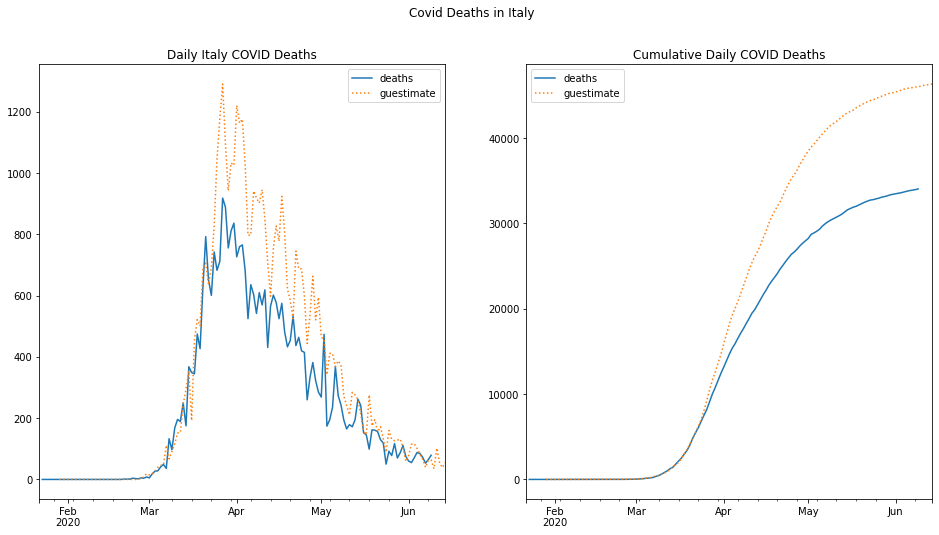

deaths    guestimate
2020-06-09  34043.0  46045.630803
2020-06-10      NaN  46080.484617
2020-06-11      NaN  46182.486177
2020-06-12      NaN  46235.653014
2020-06-13      NaN  46274.445113
2020-06-14      NaN  46329.581091

In [0]:
deaths = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
confirmed = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

deaths = deaths.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()
confirmed = confirmed.drop(["Province/State", "Lat", "Long"], axis=1).groupby("Country/Region").sum()

deaths = deaths.T
confirmed = confirmed.T

nations = {}
for nation in deaths.columns:
  nations[nation] = deaths[[nation]]
  nations[nation].columns = ["deaths"]
  nations[nation]["confirmed"] = confirmed[nation]


trgCounty = "Italy"

tmp = nations[trgCounty][["deaths", "confirmed"]]
tmp.index = pd.to_datetime(tmp.index)

my_range = 30

corr_tmp = (tmp.diff())
for i in range(my_range):
  corr_tmp["deaths_lag_{}".format(i)] = corr_tmp["deaths"].shift(i).fillna(0)
  corr_tmp["confirmed_lag_{}".format(i)] = corr_tmp["confirmed"].shift(i).fillna(0)


corr_df = corr_tmp.corr()
death_corrs = pd.DataFrame()
confirmed_corrs = pd.DataFrame()

for i in range(my_range):
  death_corrs.loc()[i, "deaths"] = corr_df.loc()["deaths", "deaths_lag_{}".format(i)]
  death_corrs.loc()[i, "confirmed"] = corr_df.loc()["deaths", "confirmed_lag_{}".format(i)]

max_correlation_days_lag = death_corrs[["confirmed"]][2:].idxmax()[0]

daily_deaths = tmp.diff()
daily_deaths.index = pd.to_datetime(daily_deaths.index)

mean_ratio = np.mean([((daily_deaths["deaths"][-i])/(daily_deaths["confirmed"][-i - max_correlation_days_lag+1])) for i in range(1,21)])
daily_deaths["guestimate"] =  mean_ratio*daily_deaths["confirmed"].shift(max_correlation_days_lag)
startForecast = daily_deaths.index.max()
cvals = daily_deaths.confirmed[-max_correlation_days_lag:]
for forecast in range(1,max_correlation_days_lag):
  daily_deaths.at[startForecast + dt.timedelta(days=forecast), "guestimate"] = mean_ratio * cvals[forecast-max_correlation_days_lag-1]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16,8), facecolor="w")
daily_deaths[["deaths", "guestimate"]].plot(ax=ax1, style=["-", ":"], title="Daily {} COVID Deaths".format(trgCounty))

#(mean_ratio * daily_deaths["confirmed"]).shift(7).plot(ax=ax1)

daily_deaths[["deaths", "guestimate"]].cumsum().plot(ax=ax2, style=["-", ":"], title="Cumulative Daily COVID Deaths")

fig.suptitle("Covid Deaths in {}".format(trgCounty))

plt.show()

display(daily_deaths[["deaths","guestimate"]].cumsum()[-max_correlation_days_lag:])